# 1. Begin

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#ignore warning
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import pickle

## 1.1. Load and preprocess data

(1) Load the data and convert InvoiceNo to string in order to identify irregularities in numerical values.

(2) Check Info and descriptive statistics.

(3) Remove null values in Description.

(4) Investigate what the values A and C in InvoiceNo represent:

A → Data entry error (invalid customer).

C → Canceled transaction.

(5) Observed overlaps:

UnitPrice < 0 → Value A

Quantity < 0 → Value C (But is it true that all cases of Quantity < 0 always correspond to InvoiceNo starting with “C”?)

(6) The answer is NO.
There are cases where Quantity < 0 occurs without “C” in InvoiceNo. The Description indicates damaged goods, meaning they were not canceled but simply could not be delivered.

(7) Remove rows with Quantity < 0 and UnitPrice < 0, and drop rows with missing CustomerID → obtain the cleaned DataFrame ‘data’.

(8) Recheck the product names in Description of ‘data’ → now all are valid goods, ready for RFM creation.

In [2]:
def load_and_preprocess_data(file_path):

    df = pd.read_csv(file_path)
    # Convert 'InvoiceNo' to string to avoid issues with mixed types
    df['InvoiceNo'] = df['InvoiceNo'].astype(str)
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

    return df

Dictionary
- InvoiceNo: Mã hóa đơn. Mỗi số hóa đơn đại diện cho một giao dịch, có thể chứa nhiều dòng sản phẩm.

- StockCode: Mã sản phẩm. Dùng để định danh từng sản phẩm trong hệ thống.

- Description: Mô tả sản phẩm (tên sản phẩm bằng văn bản).

- Quantity: Số lượng sản phẩm được mua trong dòng giao dịch đó. Giá trị âm thường thể hiện việc trả hàng (returns).

- InvoiceDate: Ngày và giờ phát sinh hóa đơn (thời điểm giao dịch).

- UnitPrice: Đơn giá của từng sản phẩm (theo 1 đơn vị sản phẩm).

- CustomerID: Mã khách hàng duy nhất. Nếu bị thiếu thì đó là giao dịch không xác định được khách hàng.

- Country: Quốc gia của khách hàng.

In [3]:
df = load_and_preprocess_data('Online Retail.csv')

In [4]:
df.head(6)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                  WHITE METAL LANTERN       6.0   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES       2.0   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
5 2010-12-01 08:26:00       7.65     17850.0  United Kingdom

In [5]:
df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  288706.000000                         288706  288706.000000   
mean        9.413403  2011-04-02 07:57:52.775210752       5.013689   
min    -74215.000000            2010-12-01 08:26:00       0.000000   
25%         1.000000            2011-01-26 13:40:00       1.250000   
50%         3.000000            2011-04-04 11:28:00       2.100000   
75%        10.000000            2011-06-07 13:31:00       4.130000   
max     74215.000000            2011-08-03 12:50:00   38970.000000   
std       204.194682                            NaN     112.381480   

          CustomerID  
count  207055.000000  
mean    15278.445703  
min     12346.000000  
25%     13837.000000  
50%     15144.000000  
75%     16818.000000  
max     18287.000000  
std      1732.456903

In [6]:
df.info()
#description và customerid có Nan cần xử lí

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288707 entries, 0 to 288706
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    288707 non-null  object        
 1   StockCode    288707 non-null  object        
 2   Description  287622 non-null  object        
 3   Quantity     288706 non-null  float64       
 4   InvoiceDate  288706 non-null  datetime64[ns]
 5   UnitPrice    288706 non-null  float64       
 6   CustomerID   207055 non-null  float64       
 7   Country      288706 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 17.6+ MB


In [7]:
#locate where customerid is null
df[df['CustomerID'].isnull()]

InvoiceNo StockCode                        Description  Quantity  \
622       536414     22139                                NaN      56.0   
1443      536544     21773    DECORATIVE ROSE BATHROOM BOTTLE       1.0   
1444      536544     21774    DECORATIVE CATS BATHROOM BOTTLE       2.0   
1445      536544     21786                 POLKADOT RAIN HAT        4.0   
1446      536544     21787              RAIN PONCHO RETROSPOT       2.0   
...          ...       ...                                ...       ...   
287943    562114     82482  WOODEN PICTURE FRAME WHITE FINISH       4.0   
288156    562134     22722                                NaN       1.0   
288157    562135     84847                                NaN       1.0   
288519    562164     21257                                  ?     -94.0   
288706    562203     21977          PACK OF 60 PINK PAISLEY C       NaN   

               InvoiceDate  UnitPrice  CustomerID         Country  
622    2010-12-01 11:52:00       0.00         NaN  United Kingdom  
1443   2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1444   2010-12-01 14:32:00       2.51         NaN  United Kingdom  
1445   2010-12-01 14:32:00       0.85         NaN  United Kingdom  
1446   2010-12-01 14:32:00       1.66         NaN  United Kingdom  
...                    ...        ...         ...             ...  
287943 2011-08-02 16:14:00       2.55         NaN  United Kingdom  
288156 2011-08-03 09:50:00       0.00         NaN  United Kingdom  
288157 2011-08-03 09:50:00       0.00         NaN  United Kingdom  
288519 2011-08-03 12:08:00       0.00         NaN  United Kingdom  
288706                 NaT        NaN         NaN             NaN  

[81652 rows x 8 columns]

In [8]:
#locate where description is nan
df[df['Description'].isnull()]
#nếu description là nan thì chúng ta không biết khách hàng mua gì khi UnitPrice = 0
#dropnan description

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
622       536414     22139         NaN      56.0 2010-12-01 11:52:00   
1970      536545     21134         NaN       1.0 2010-12-01 14:32:00   
1971      536546     22145         NaN       1.0 2010-12-01 14:33:00   
1972      536547     37509         NaN       1.0 2010-12-01 14:33:00   
1987      536549    85226A         NaN       1.0 2010-12-01 14:34:00   
...          ...       ...         ...       ...                 ...   
285725    561919    85017B         NaN    -188.0 2011-08-01 12:08:00   
285727    561921     22044         NaN    -240.0 2011-08-01 12:11:00   
285790    561924     22042         NaN    -197.0 2011-08-01 12:27:00   
288156    562134     22722         NaN       1.0 2011-08-03 09:50:00   
288157    562135     84847         NaN       1.0 2011-08-03 09:50:00   

        UnitPrice  CustomerID         Country  
622           0.0         NaN  United Kingdom  
1970          0.0         NaN  United Kingdom  
1971          0.0         NaN  United Kingdom  
1972          0.0         NaN  United Kingdom  
1987          0.0         NaN  United Kingdom  
...           ...         ...             ...  
285725        0.0         NaN  United Kingdom  
285727        0.0         NaN  United Kingdom  
285790        0.0         NaN  United Kingdom  
288156        0.0         NaN  United Kingdom  
288157        0.0         NaN  United Kingdom  

[1085 rows x 8 columns]

In [9]:
for col in df['Description'].unique():
    print(col)
#nhiều mục sai (mixed up, lost, missing, ???? need, gift, test, sample, damaged, error)
# Cùng tìm hiểu nó là gì nào

WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA

In [10]:
df = df.dropna(subset=['Description'])

In [11]:

#find not normal 6 digits invoice
df[df['InvoiceNo'].str.match('^\d{6}$') == False]
#ALl non-6 digits invoice have C before their No
# Chúng ta thấy các customer này thường có quantity là âm, hãy kiểm tra nó xem
 #C must be Cancel customer

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount      -1.0   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS      -1.0   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE      -12.0   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES      -24.0   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES      -24.0   
...          ...       ...                               ...       ...   
288328   C562154     23256       CHILDRENS CUTLERY SPACEBOY       -4.0   
288419   C562159         M                            Manual     -12.0   
288420   C562160     22456   NATURAL SLATE CHALKBOARD LARGE       -4.0   
288592   C562185     22381            TOY TIDY PINK POLKADOT      -3.0   
288593   C562188    85099B           JUMBO BAG RED RETROSPOT    -100.0   

               InvoiceDate  UnitPrice  CustomerID         Country  
141    2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154    2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235    2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236    2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237    2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
...                    ...        ...         ...             ...  
288328 2011-08-03 11:23:00       4.15     13520.0     Switzerland  
288419 2011-08-03 11:48:00       1.45     17389.0  United Kingdom  
288420 2011-08-03 11:50:00       4.25     13106.0  United Kingdom  
288592 2011-08-03 12:15:00       2.10     12748.0  United Kingdom  
288593 2011-08-03 12:16:00       1.79     12748.0  United Kingdom  

[5244 rows x 8 columns]

In [12]:
Damage_customers = df[df['InvoiceNo'].str.match('^\d{6}$') == True & (df['Quantity'] < 0)]
# Damage_customers['Description'].unique().tolist()
# Description đều báo lỗi chứng tỏ các các khách hàng này là Damages/Stock Corrections

In [13]:
Cancel_customers = df[df['InvoiceNo'].str.match('^\d{6}$') == False & (df['Quantity'] < 0)]
# Cancel_customers
#Description bình thường chứng tỏ đây là nhóm rời bỏ Churn
#Sau khi phân cụm xong nhóm này sẽ là Cancel

In [14]:
df[df['UnitPrice'] < 0]
#Unit price < 0 is simply wrong value we will drop it
# A này có thể là khách hàng bị đuổi vì nợ xấu
# 2 dòng này sẽ bị loại khỏi bài đến cuối cùng luôn

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

In [15]:
df.dropna(subset=['CustomerID'], inplace=True)

In [16]:
#lấy df khi quantity và unitprce >0
data = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [17]:
for col in data['Description'].unique():
    print(col)
#các mục sai đã hết sau khi drop quantity < 0

WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA

In [18]:
# Số cột mà sau khi grouby sẽ có
data['CustomerID'].nunique()

3173

1.2. Feature Engineering

(These will be the three main variables used for the KMeans clustering model)

(1) Recency: Calculated as the last day (max) of the entire dataset + 1 (to represent the analysis date) minus the most recent purchase date of each customer.

If a customer purchased recently → the number of days is small.

If a customer has not purchased for a long time → the number of days is large.

(2) Frequency: Defined as the count of InvoiceNo. However, since all invoices occurring on the same day may not reflect true purchasing frequency,
→ use distinct count of purchase dates instead.

(3) Monetary: Calculated as the total spending (Total Price) for each customer.

In [19]:
def calculate_total_price(data):
    data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
    return data
data = calculate_total_price(data)
data.head(2)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                 WHITE METAL LANTERN       6.0   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34

In [20]:
import datetime as dt
def create_rfm_features(df):
    snapshot_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

    # RFM
    rfm = data.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,           # Recency
        'InvoiceNo': 'nunique',         # Frequency
        'TotalPrice': 'sum'             # Monetary
    }).reset_index()

    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    return rfm

rfm = create_rfm_features(data)
rfm.head()


CustomerID  Recency  Frequency  Monetary
0     12346.0      198          1  77183.60
1     12347.0        2          5   2790.86
2     12348.0      121          3   1487.24
3     12350.0      182          1    334.40
4     12352.0      134          5   1561.81

In [21]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3173 non-null   float64
 1   Recency     3173 non-null   int64  
 2   Frequency   3173 non-null   int64  
 3   Monetary    3173 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 99.3 KB


# 2. Exploratory Data Analysis

## 2.1. Trend and Seasonality

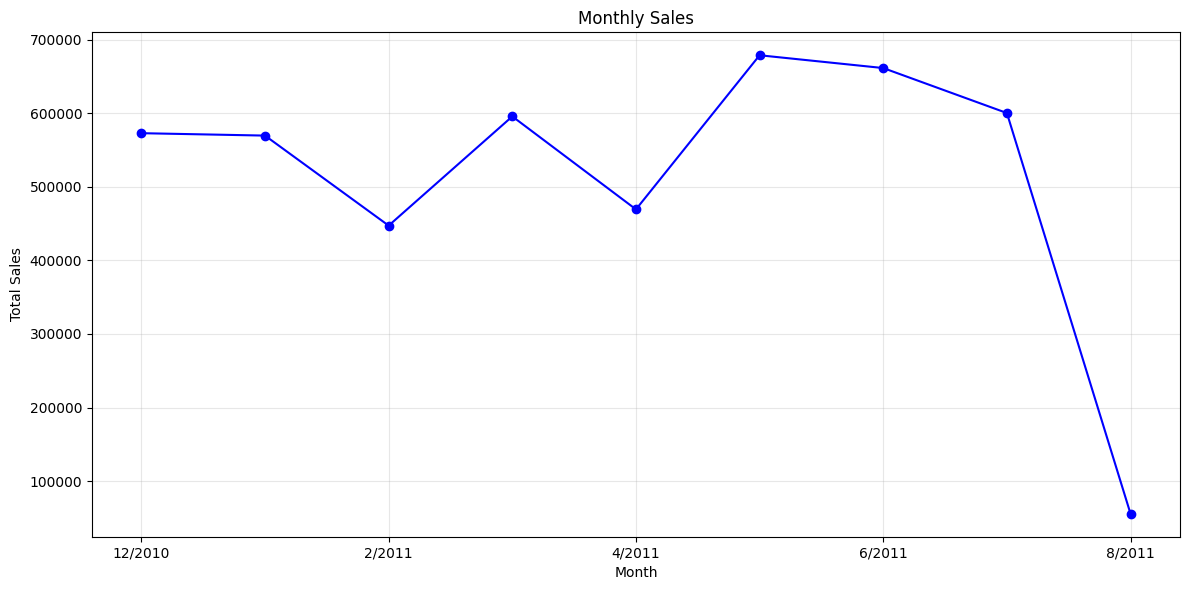

In [22]:
plt.figure(figsize=(12, 6))
monthly_sales = data.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()

# Plot with month numbers
plt.plot(range(len(monthly_sales)), monthly_sales.values, marker='o' , color = 'blue')

# Show every other month label
plt.xticks(range(0, len(monthly_sales), 2),
[f'{date.month}/{date.year}' for date in monthly_sales.index][::2])

plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In 2011, sales remained at an average level during most months but showed a sharp spike from September to November, peaking in November. This reflects a “hockey stick curve” trend, most likely driven by:

Increased shopping demand during the year-end holiday season (Christmas in the UK).

The company clearing out inventory stock.

Sales staff striving to meet year-end targets, bonuses, and quotas.

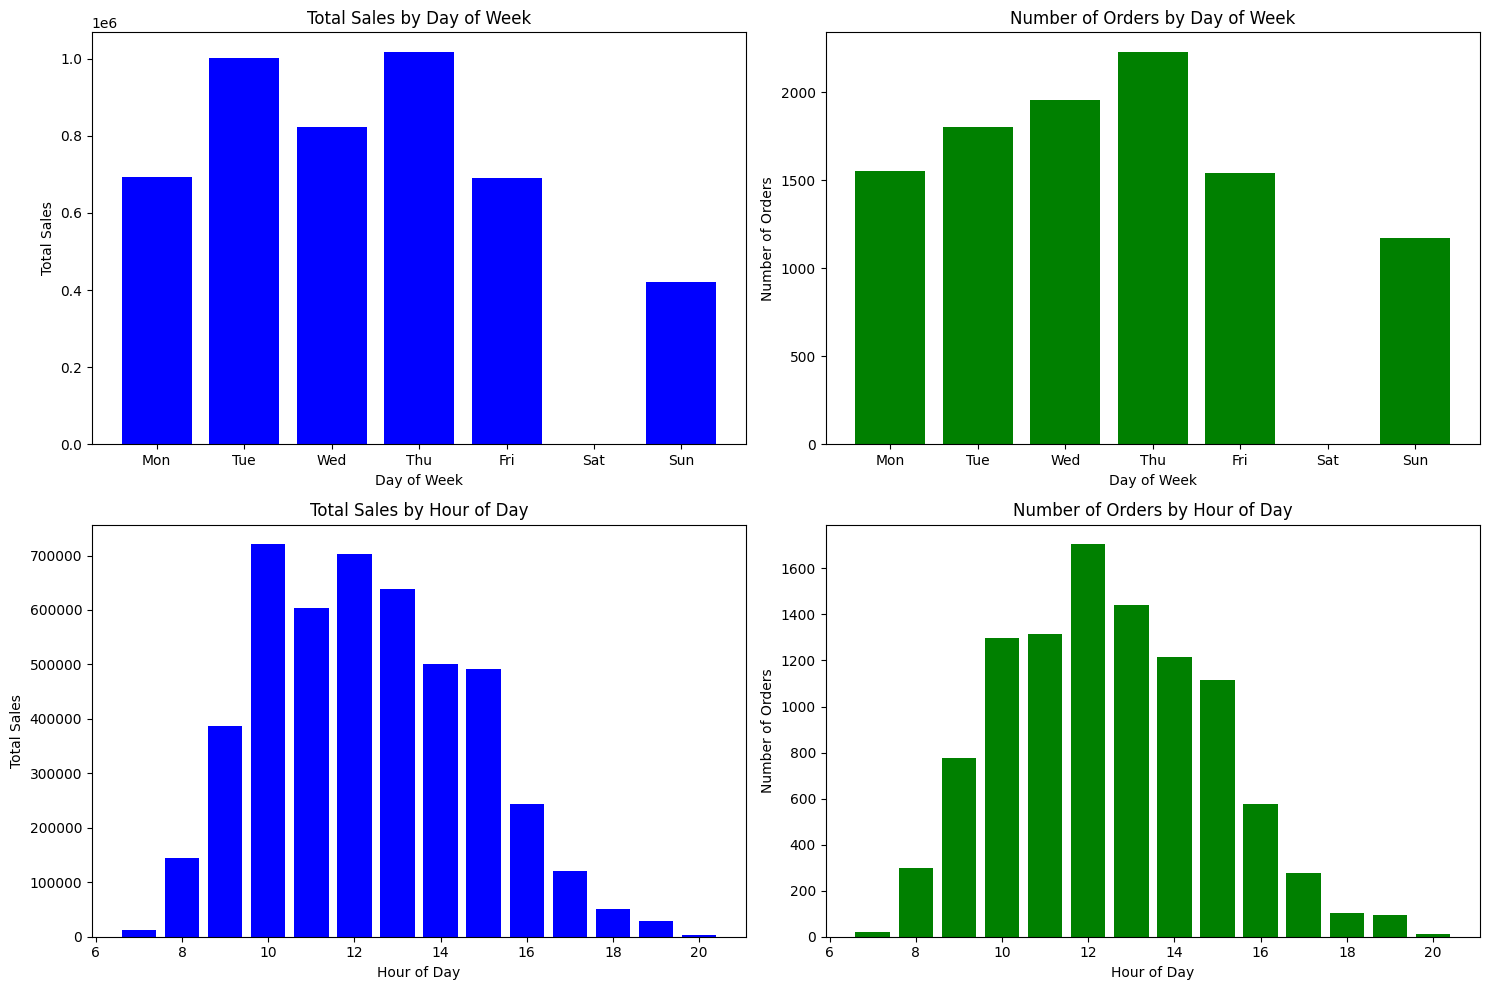

In [23]:
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
data['HourOfDay'] = data['InvoiceDate'].dt.hour

dayofweek_sales = data.groupby('DayOfWeek')['TotalPrice'].sum()
dayofweek_orders = data.groupby('DayOfWeek')['InvoiceNo'].nunique()
hourofday_sales = data.groupby('HourOfDay')['TotalPrice'].sum()
hourofday_orders = data.groupby('HourOfDay')['InvoiceNo'].nunique()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Total Sales by Day of Week
axes[0, 0].bar(dayofweek_sales.index, dayofweek_sales.values, color = 'blue')
axes[0, 0].set_title('Total Sales by Day of Week')
axes[0, 0].set_xlabel('Day of Week')
axes[0, 0].set_ylabel('Total Sales')
axes[0, 0].set_xticks(range(7)) # Set ticks for all 7 days
axes[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


# Plot Number of Orders by Day of Week
axes[0, 1].bar(dayofweek_orders.index, dayofweek_orders.values, color = 'green')
axes[0, 1].set_title('Number of Orders by Day of Week')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].set_xticks(range(7)) # Set ticks for all 7 days
axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plot Total Sales by Hour of Day
axes[1, 0].bar(hourofday_sales.index, hourofday_sales.values, color='blue')
axes[1, 0].set_title('Total Sales by Hour of Day')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Total Sales')


# Plot Number of Orders by Hour of Day
axes[1, 1].bar(hourofday_orders.index, hourofday_orders.values, color = 'green')
axes[1, 1].set_title('Number of Orders by Hour of Day')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Number of Orders')


plt.tight_layout()
plt.show()

Sales activity (both in terms of revenue and number of orders) shows significant variation by both day of the week and time of day.

1. By day of the week:

Thursday records the highest total revenue and number of orders. This suggests that customers tend to shop the most in the middle of the week, possibly linked to promotional programs or shopping habits before the weekend.

Saturday has the lowest revenue and order volume. This is quite reasonable, as it could be the store’s day off or customers may prefer other weekend activities rather than shopping online from this store.

The other weekdays (Monday, Tuesday, Wednesday, Friday) show relatively stable levels of sales and orders—lower than Thursday but higher than Saturday.

2. By time of day:

Sales activity is concentrated mainly during business hours, from around 9 a.m. to 4 p.m. (16:00).

12 p.m. (noon) marks the peak in both revenue and order volume. This may be the time when customers take advantage of their lunch break to shop.

There is a significant decline in sales and orders in the late afternoon and evening.

Very little or almost no sales activity occurs outside of business hours and at night.

## 2.2 Phân tích theo Địa Lý (Geographical Analysis)

### 2.2.1 Function for Distribution Plot

In [24]:

def plot_top_countries(data, grp ,col, n):
    country_sales = data.groupby(grp)[col].sum().sort_values(ascending=False)
    top_countries = country_sales.head(n)

    total_sales_top_countries = country_sales.sum()
    percentage_contribution = (top_countries / total_sales_top_countries) * 100

    colors = ['lightgreen', 'red', 'blue', 'orange', 'purple']

    ax = percentage_contribution.plot(kind='barh', color=colors)
    plt.title(f'Top 5 by {grp} Percentage Contribution to {col}')
    plt.xlabel(f'Percentage Contribution to {col}')
    plt.ylabel(f'{grp}')
    plt.grid()

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')
    plt.show()

def plot_least(data, grp ,col, n):
    country_sales = data.groupby(grp)[col].sum().sort_values(ascending=True)
    top_countries = country_sales.head(n)

    total_sales_top_countries = country_sales.sum()
    percentage_contribution = (top_countries / total_sales_top_countries) * 100

    colors = ['lightgreen', 'red', 'blue', 'orange', 'purple']

    ax = percentage_contribution.plot(kind='barh', color=colors)
    plt.title(f'Top 5 by {grp} Percentage Contribution to {col}')
    plt.xlabel(f'Percentage Contribution to {col}')
    plt.ylabel(f'{grp}')
    plt.grid()

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')
    plt.show()

### 2.2.2 Sales Distribution by Country

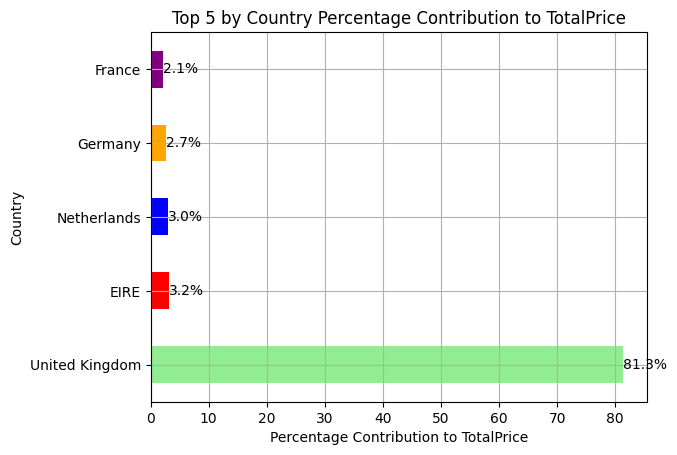

In [25]:
# PLOTTING PERCENTAGE ON GRAPH TO SHOW HOW MUCH DIFFERENT COUNTRIES CONTRIBUTE TO THE SALES
plot_top_countries(data, 'Country','TotalPrice', 5)

The business has a high dependency on the UK market, which contributes approximately 88.1% of total sales.
While this could indicate market expertise, it also presents a risk of over-reliance on a single country; geopolitical crises or changes in regulations could significantly impact the business.
Diversification into other countries is suggested to mitigate this risk, or a strong focus on providing excellent service to UK customers if diversification is not a priority.

### 2.2.3 Customers Distribution by Country

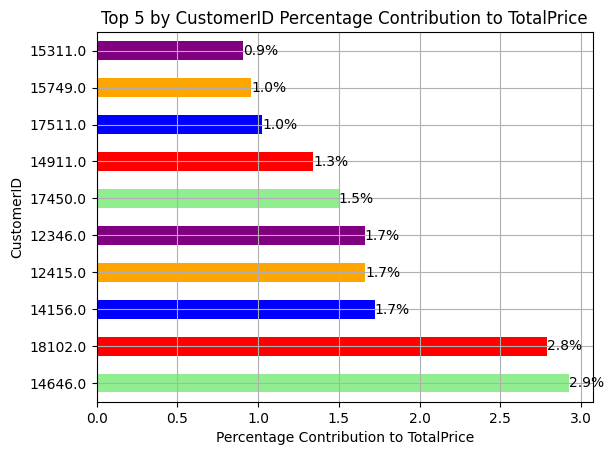

In [26]:
# PLOT TO SEE 10 BEST CUSTOMERS OF THE STORES
plot_top_countries(data, 'CustomerID','TotalPrice', 10)


## 2.3. Phân tích sản phẩm (Product Performance Analysis)

### 2.3.1 Sản phẩm bán chạy (Top Products)

The best-selling product, “PAPER CRAFT,” accounts for only about 1.9% of the total product sales.

This indicates that the company’s product portfolio is quite diverse and not overly dependent on a single item – a positive signal for business stability.

Top 10 Most Sold Products (by Quantity):
Description
MEDIUM CERAMIC TOP STORAGE JAR        76200.0
WORLD WAR 2 GLIDERS ASSTD DESIGNS     34660.0
JUMBO BAG RED RETROSPOT               25176.0
WHITE HANGING HEART T-LIGHT HOLDER    25126.0
PACK OF 72 RETROSPOT CAKE CASES       23014.0
ASSORTED COLOURS SILK FAN             18456.0
SMALL POPCORN HOLDER                  18004.0
ASSORTED COLOUR BIRD ORNAMENT         16924.0
PACK OF 60 PINK PAISLEY CAKE CASES    16834.0
PACK OF 12 LONDON TISSUES             16793.0
Name: Quantity, dtype: float64


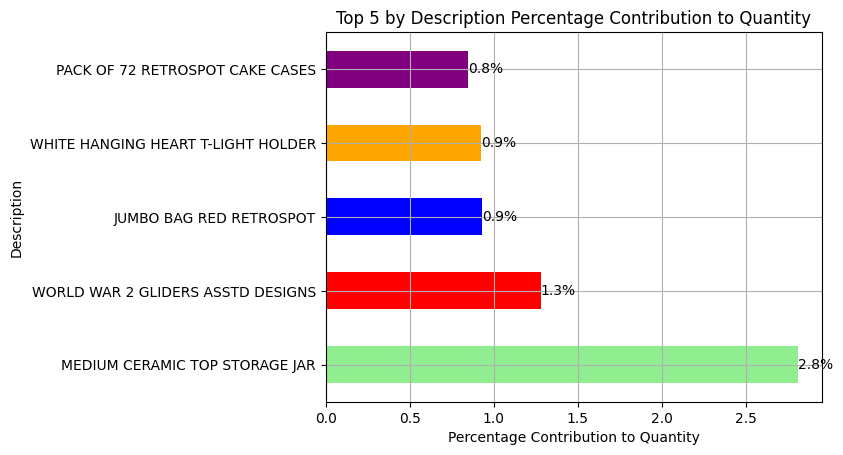


Top 10 Most Sold Products (by Total Price):
Description
REGENCY CAKESTAND 3 TIER              98042.95
MEDIUM CERAMIC TOP STORAGE JAR        79443.09
WHITE HANGING HEART T-LIGHT HOLDER    68152.94
PARTY BUNTING                         51800.15
POSTAGE                               45922.01
JUMBO BAG RED RETROSPOT               45640.68
PICNIC BASKET WICKER 60 PIECES        39619.50
ASSORTED COLOUR BIRD ORNAMENT         27630.04
CHILLI LIGHTS                         25575.01
WOOD BLACK BOARD ANT WHITE FINISH     23517.85
Name: TotalPrice, dtype: float64


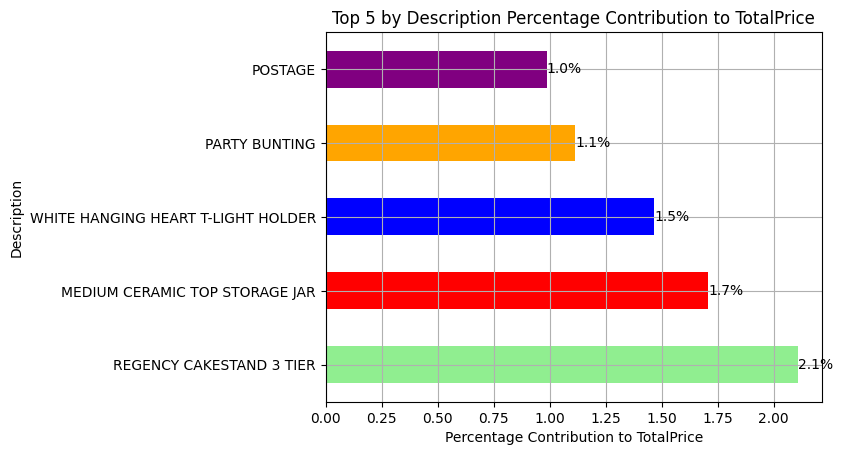

In [27]:
# Identify top 10 most sold products by quantity
top_selling_products_quantity = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

print("Top 10 Most Sold Products (by Quantity):")
print(top_selling_products_quantity)

# PLOT TO SEE THE 5 BEST PRODUCTS
plot_top_countries(data, 'Description','Quantity', 5)

# Identify top 10 most sold products by total price
top_selling_products_price = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

print("\nTop 10 Most Sold Products (by Total Price):")
print(top_selling_products_price)


plot_top_countries(data, 'Description','TotalPrice', 5)


### 2.3.2 Sản phẩm kẹm chạy (Least Products)

In [28]:
# Identify 10 least sold products by quantity
least_selling_products_quantity = data.groupby('Description')['Quantity'].sum().sort_values(ascending=True).head(5)

print("\n10 Least Sold Products (by Quantity):")
print(least_selling_products_quantity)
# Insight: Có nhiều sản phẩm chỉ bán được số lượng rất ít (chỉ 1 sản phẩm), có thể cần xem xét lại việc duy trì các mặt hàng này trong kho.

# plot_least(data, 'Description','Quantity', 5)

# Identify 10 least sold products by total price
least_selling_products_price = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=True).head(5)

print("\n10 Least Sold Products (by Total Price):")
print(least_selling_products_price)
# Insight: Một số sản phẩm có tổng doanh thu rất thấp, thậm chí gần bằng 0, điều này có thể là do giá trị đơn vị thấp hoặc số lượng bán ra không đáng kể.

# plot_least(data, 'Description','TotalPrice', 5)


10 Least Sold Products (by Quantity):
Description
TEA TIME BREAKFAST BASKET            1.0
TEAL/FUSCHIA COL BEAD NECKLACE       1.0
JARDIN ETCHED GLASS BUTTER DISH      1.0
PURPLE CHUNKY GLASS+BEAD NECKLACE    1.0
PACKING CHARGE                       1.0
Name: Quantity, dtype: float64

10 Least Sold Products (by Total Price):
Description
PADS TO MATCH ALL CUSHIONS    0.002
GOLD FABRIC MIRROR            0.390
SILICON CUBE 25W, BLUE        0.420
HEN HOUSE W CHICK IN NEST     0.420
ASSTD RASTA KEY-CHAINS        0.420
Name: TotalPrice, dtype: float64


## 2.4. Explore Cancellations and Returns

In [29]:
# Analyze cancelled orders
cancelled_orders = df[df['InvoiceNo'].str.contains('C', na=False)]

print("Number of cancelled orders:", len(cancelled_orders))
print("\nSample of cancelled orders:")
display(cancelled_orders.head())

# Phân tích tác động của việc hủy đơn hàng lên tổng doanh số (tùy vào việc mình định nghĩa tác động này là gì)
# Vd có thể so sánh tổng doanh số trước và sau khi xóa các đơn hàng đã hủy

Number of cancelled orders: 4977

Sample of cancelled orders:


InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount      -1.0   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS      -1.0   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE      -12.0   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES      -24.0   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES      -24.0   

            InvoiceDate  UnitPrice  CustomerID         Country  
141 2010-12-01 09:41:00      27.50     14527.0  United Kingdom  
154 2010-12-01 09:49:00       4.65     15311.0  United Kingdom  
235 2010-12-01 10:24:00       1.65     17548.0  United Kingdom  
236 2010-12-01 10:24:00       0.29     17548.0  United Kingdom  
237 2010-12-01 10:24:00       0.29     17548.0  United Kingdom

## 2.5. RFM Distribution

From the figure, we can see that the data becomes clearly different starting from around 100–150 days.

→ Therefore, we will set a threshold of 150: if a customer does not make a purchase for more than 150 days, we can consider that customer as churned.

--- Will a Machine Learning model recognize this as a cluster?

In [30]:
customer_last_purchase = rfm['Recency']
churn_threshold = 150 # Tạo ngưỡng rời bỏ là 150
churn_customers = rfm[customer_last_purchase > churn_threshold]
churn_customers.shape

(585, 4)

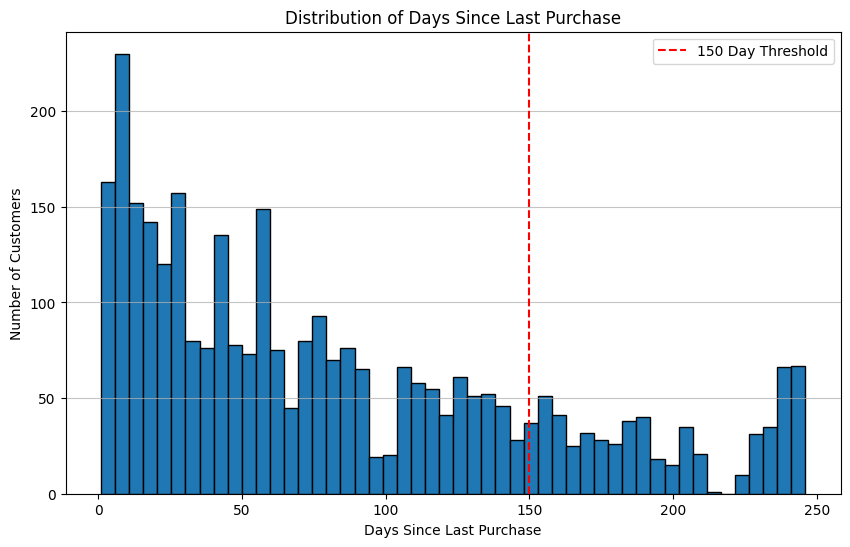

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(customer_last_purchase, bins=50, edgecolor='black')
plt.axvline(x=150, color='red', linestyle='--', label='150 Day Threshold')
plt.title('Distribution of Days Since Last Purchase')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

### 2.6. Investigate Null and Outliers

RFM not have NULL value

RFM has too many Outliers in Frequency and Monetary that shape the box plot

### 2.6.1. Kiểm tra NaN value

In [32]:
rfm.isnull().sum()

CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64

### 2.6.2. Kiểm tra Outliers

In [33]:
rfm.describe()

CustomerID      Recency    Frequency       Monetary
count   3173.000000  3173.000000  3173.000000    3173.000000
mean   15293.329026    82.673810     3.229121    1465.324337
std     1724.495772    68.922658     5.141884    5319.468468
min    12346.000000     1.000000     1.000000       2.900000
25%    13805.000000    24.000000     1.000000     254.960000
50%    15249.000000    62.000000     2.000000     534.570000
75%    16779.000000   129.000000     3.000000    1251.750000
max    18287.000000   246.000000   116.000000  136028.130000

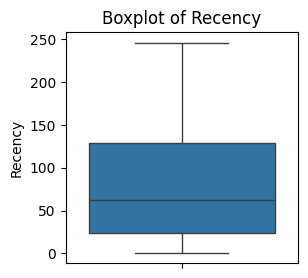

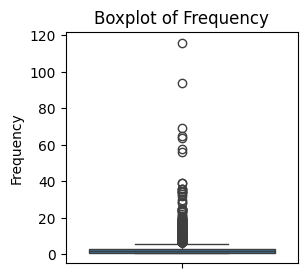

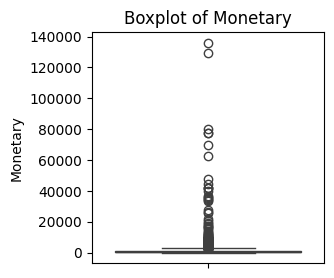

In [34]:
# Plotting boxplots for R, F, M
def plot_boxplot(column, data):
    plt.figure(figsize=(3, 3))
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
    #plt.ylim(lower_bound - 10, upper_bound + 10)
    plt.show()

for col in ['Recency', 'Frequency', 'Monetary']:
    plot_boxplot(col, rfm)

# R không nhiều outlier
# F, M có nhiều outlier cần bỏ đi để tiến hành phân cụm
# -3 : Nhóm có outlier F nhưng ko có M
# -2: Nhóm có outlier M nhưng ko có F
# -1: Nhóm có cả 2 outlier

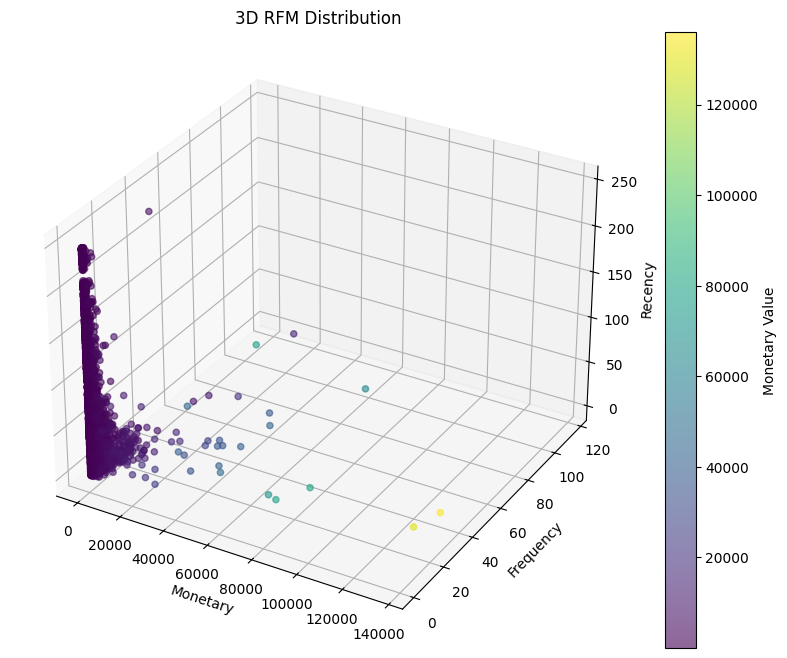

In [35]:
def plot_3d_rfm(df):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(df['Monetary'],
                        df['Frequency'],
                        df['Recency'],
                        c=df['Monetary'],
                        cmap='viridis',
                        alpha=0.6)

    ax.set_xlabel('Monetary')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Recency')

    plt.colorbar(scatter, label='Monetary Value')
    plt.title('3D RFM Distribution')
    plt.show()

plot_3d_rfm(rfm)
# Có quá nhiều outlier cần phải được xử lí

### 2.6.3. Outliers
#### 3 New Dataframe:
#### - rfm
#### - outliers_df
#### - non_outliers_df

Outlier Processing and Clustering Plan
Based on the results of outlier analysis, we can proceed as follows:

(1) Function Creation: Create two separate functions: one to retrieve the non-outlier dataset and another to retrieve the outlier dataset. Both datasets will be used in this analysis.

(2) Non-Outlier Data Goal:

Use the non-outlier data with K-Means, as this algorithm is highly sensitive to outliers.

Evaluate whether using a log transformation on the data leads to better clustering results. We will measure this using metrics such as Dunn, CH, DBI, and Silhouette Score to determine the optimal approach.

After performing the clustering on the non-outlier data, we will combine these clusters with the clusters of the outlier data, specifically: outliers from Frequency, outliers from Monetary, and outliers from both.

(3) DBSCAN with Original RFM Data:

Use the original RFM dataset (without outlier removal) for clustering with the DBSCAN algorithm. This approach is beneficial because DBSCAN is robust to outliers and can identify them as noise points.

In [36]:
#function for only outliers
def outlier_dataframe(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] < lower_bound) | (data[col] > upper_bound)]

#function for only non outliers
def non_outlier_dataframe(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

f_outliers = outlier_dataframe(rfm, 'Frequency')
m_outliers = outlier_dataframe(rfm, 'Monetary')

f_non_outliers = non_outlier_dataframe(rfm['Frequency'])
m_non_outliers = non_outlier_dataframe(rfm['Monetary'])

In [37]:
#put a non_outliers_df of what index is in f_non_outliers and m_non_outliers
non_outliers_df = rfm[rfm['Frequency'].isin(f_non_outliers) & rfm['Monetary'].isin(m_non_outliers)]
non_outliers_data = non_outliers_df.copy()

In [38]:
non_outliers_df.drop(columns=[ 'CustomerID'], inplace=True)

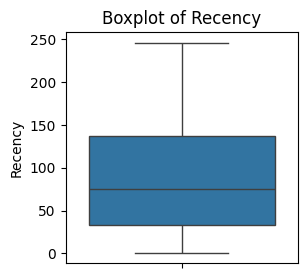

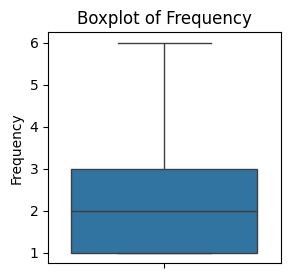

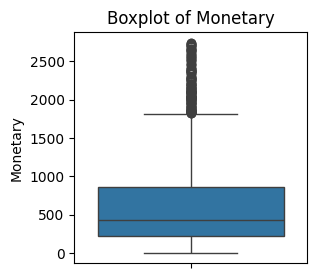

In [39]:
for col in ['Recency', 'Frequency', 'Monetary']:
    plot_boxplot(col, non_outliers_df)
#các box mới đã đỡ xẹp hơn

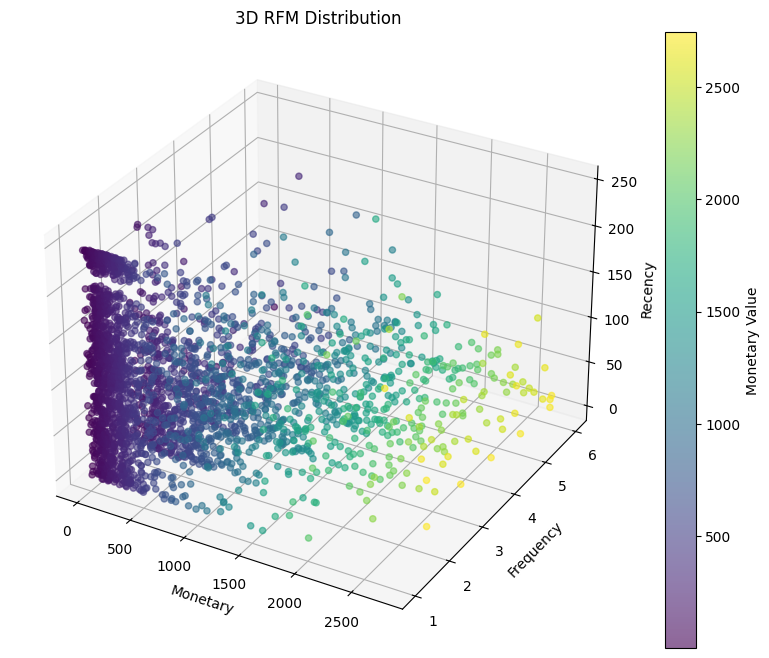

In [40]:
plot_3d_rfm(non_outliers_df)

### 2.6.4. Xem xét RFM xem data có skewed không? Nếu có xử dụng Log Transform

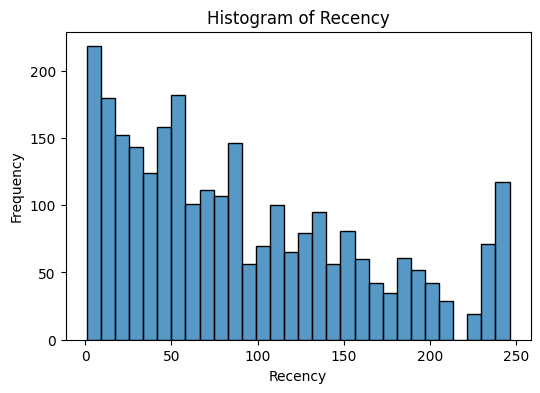

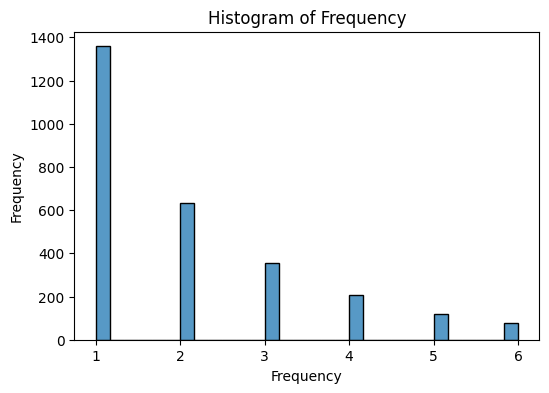

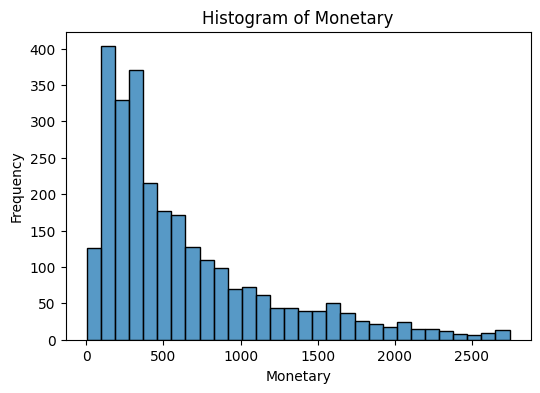

In [41]:
#plot histogram non_outliers_df
for col in non_outliers_df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(non_outliers_df[col], bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

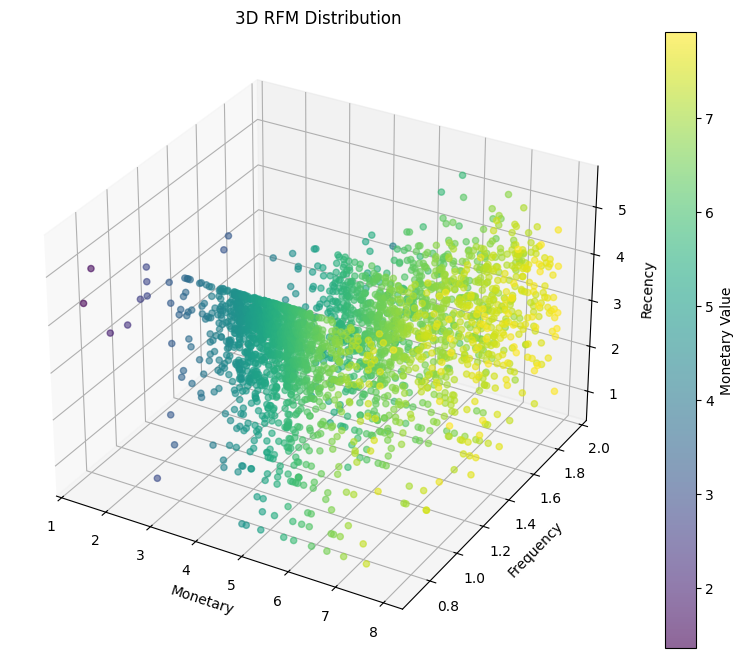

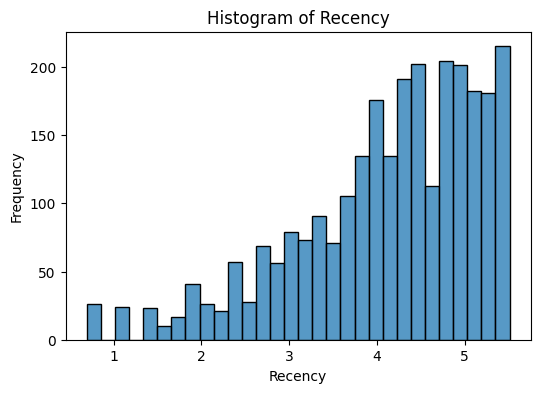

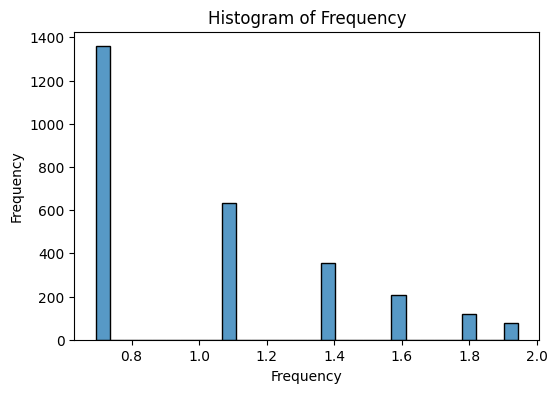

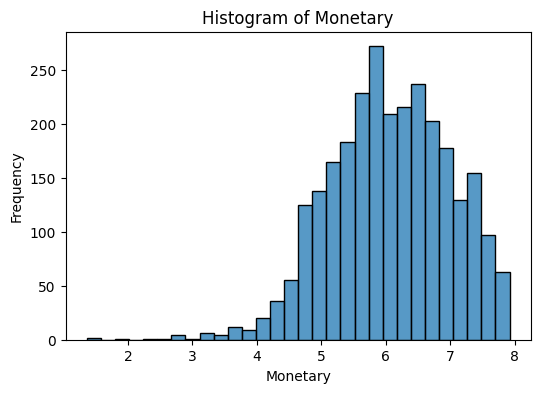

In [42]:
def log_transform(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df_log = df.copy()
    df_log[numeric_cols] = np.log1p(df_log[numeric_cols])
    return df_log

non_outliers_df_log = log_transform(non_outliers_df)

plot_3d_rfm(non_outliers_df_log)

for col in non_outliers_df_log.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(non_outliers_df_log[col], bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# 3. Xây dựng mô hình học máy (Build ML Model)

## 3.1. Normalization

### 3.1.1 StandardScaler

In [43]:
def standard_scale(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

standard_scale(non_outliers_df_log)

standard_scale(non_outliers_df)

standard_scale(rfm)

CustomerID   Recency  Frequency   Monetary
0      -1.709365  1.673533  -0.433590  14.236424
1      -1.708786 -1.170682   0.344457   0.249225
2      -1.708206  0.556163  -0.044567   0.004121
3      -1.707046  1.441353  -0.433590  -0.212635
4      -1.705886  0.744810   0.344457   0.018141
...          ...       ...        ...        ...
3168    1.728123  0.686765  -0.433590  -0.265919
3169    1.732183  0.976991  -0.433590  -0.241552
3170    1.732763 -0.430606  -0.433590  -0.260312
3171    1.733923 -0.909479   1.122505  -0.090165
3172    1.736242 -0.125868  -0.433590  -0.131621

[3173 rows x 4 columns]

### 3.1.2 Min Max Scaler

In [44]:
# def min_max_scale(df):
#     numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
#     scaler = MinMaxScaler()
#     df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
#     return df

# min_max_scale(non_outliers_df_log)

# min_max_scale(non_outliers_df)

# min_max_scale(rfm)
# rfm.drop(columns = 'CustomerID', inplace = True, axis = 1)

## 3.2. KMeans Model


### 3.2.1 WCSS

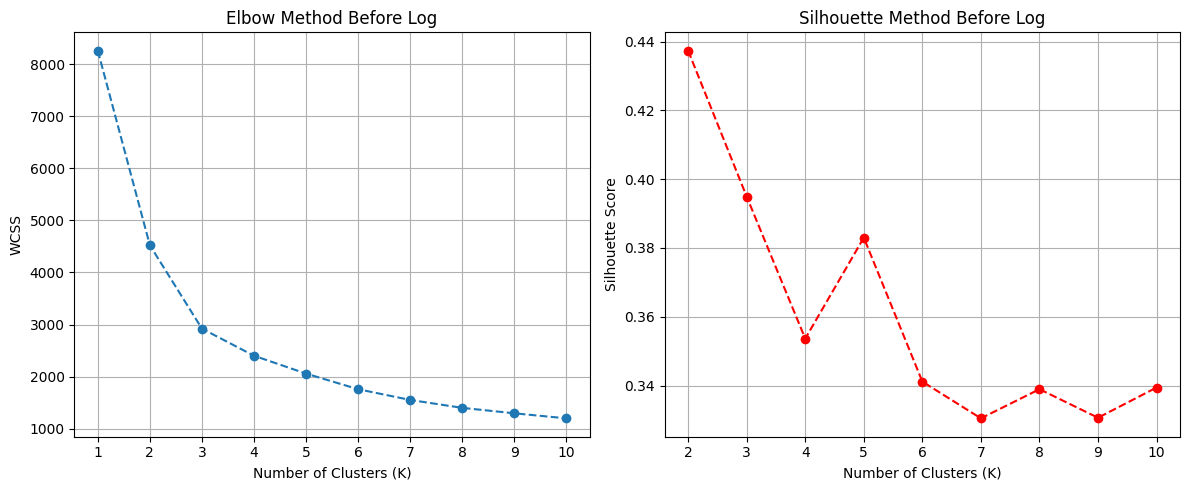

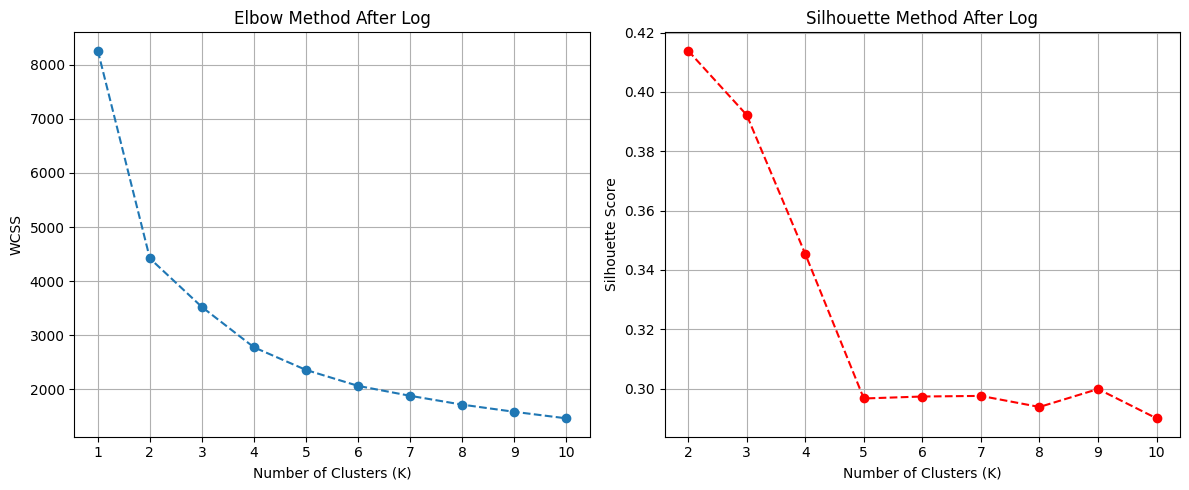

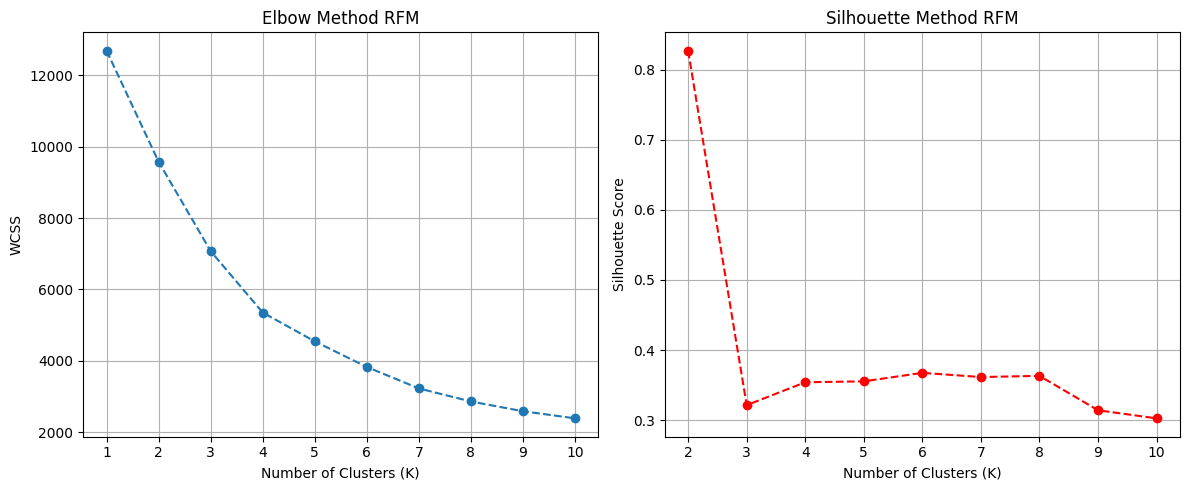

In [45]:
#Đơn thuần là gán giá trị để đặt tên phân biệt, không gọi hàm
non_outliers_df.name = 'Before Log'
non_outliers_df_log.name = 'After Log'
rfm.name = "RFM"
def find_optimal_k_wcss(data, max_k):
    wcss = []
    for i in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot WCSS
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
    plt.title(f'Elbow Method {data.name}')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('WCSS')
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)

    # Calculate silhouette scores
    silhouette_scores = []
    for i in range(2, max_k + 1):  # Silhouette score needs at least 2 clusters
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))

    # Plot Silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='--', color = 'red')
    plt.title(f'Silhouette Method {data.name}')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, max_k + 1))
    plt.grid(True)
    plt.tight_layout()

# Example usage (replace non_outliers_df_log with your data)
# You might want to experiment with different max_k values
find_optimal_k_wcss(non_outliers_df, 10)

find_optimal_k_wcss(non_outliers_df_log, 10)

find_optimal_k_wcss(rfm, 10)

# Silhouette accuracy after Log is significantly lower than before log -> Choose Before log
# choosing k=3

### 3.2.2 FUNCTION TO USE KMEANS

In [46]:
def perform_kmeans_clustering(data, n_clusters):
    # Model
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data)
    labels = kmeans.labels_

    #3 basic index
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies = davies_bouldin_score(data, labels)

    # Dunn Index
    distances = euclidean_distances(data)

    ## Max intra-cluster distance (diameter)
    max_intra = 0
    for cluster in np.unique(labels):
        cluster_idx = np.where(labels == cluster)[0]
        if len(cluster_idx) > 1:
            intra_dist = distances[np.ix_(cluster_idx, cluster_idx)].max()
            max_intra = max(max_intra, intra_dist)

    ## Min inter-cluster distance
    min_inter = np.inf
    unique_labels = np.unique(labels)
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i_idx = np.where(labels == unique_labels[i])[0]
            cluster_j_idx = np.where(labels == unique_labels[j])[0]
            inter_dist = distances[np.ix_(cluster_i_idx, cluster_j_idx)].min()
            min_inter = min(min_inter, inter_dist)

    dunn_index = min_inter / max_intra if max_intra > 0 else 0

    #Print
    print(f"Silhouette Score: {silhouette}")
    print(f"Calinski-Harabasz Score: {calinski}")
    print(f"Davies-Bouldin Score: {davies}")
    print(f"Dunn Index: {dunn_index}")

    #Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data.iloc[:, 2], data.iloc[:, 1], data.iloc[:, 0], c=labels)
    ax.set_title('K-Means Clustering Results (3D)')
    ax.set_xlabel('Monetary')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('R')
    plt.show()

    #PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])
    pca_df['cluster'] = labels
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=pca_df, palette='viridis', legend='full')
    plt.title('K-Means Clustering Results (PCA)')
    plt.show()

    return labels, kmeans

Khi sử dụng DUNN INDEX vào mô hình Kmeans khiến cho max intra bị phình to ra -> Dunn Index nhỏ
Chỉ kỳ vọng dunn index trong khoảng 0.001 đến 0.2

#### 3.2.2.1. RFM still have Outliers

Silhouette Score: 0.3539598846793806
Calinski-Harabasz Score: 1449.2956042542164
Davies-Bouldin Score: 0.9115995934899964
Dunn Index: 0.0012285513971074444


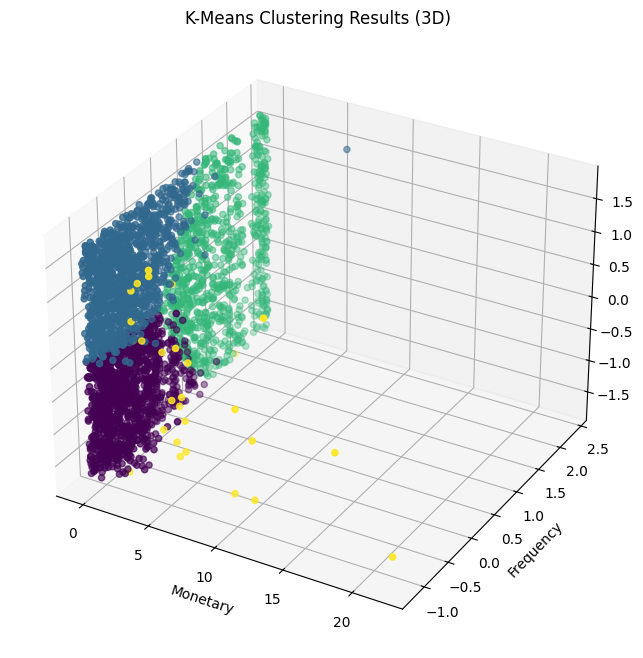

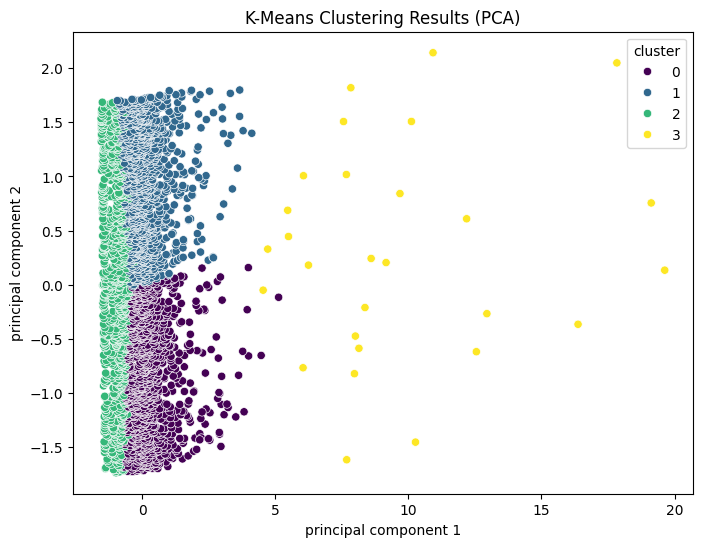

In [47]:
labels_rfm, kmeans_rfm = perform_kmeans_clustering(rfm, n_clusters=4)

Bị ảnh hưởng nhiều bởi outliers dữ liệu chồng chéo lên nhau

#### 3.2.2.2. RFM with no outliers

Silhouette Score: 0.3536415821174008
Calinski-Harabasz Score: 2234.2557237109395
Davies-Bouldin Score: 1.042159086364241
Dunn Index: 0.002415955127313328


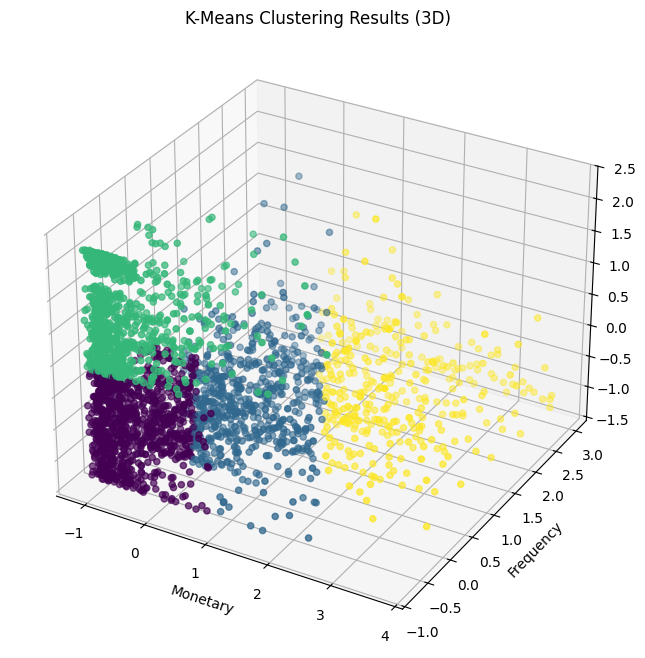

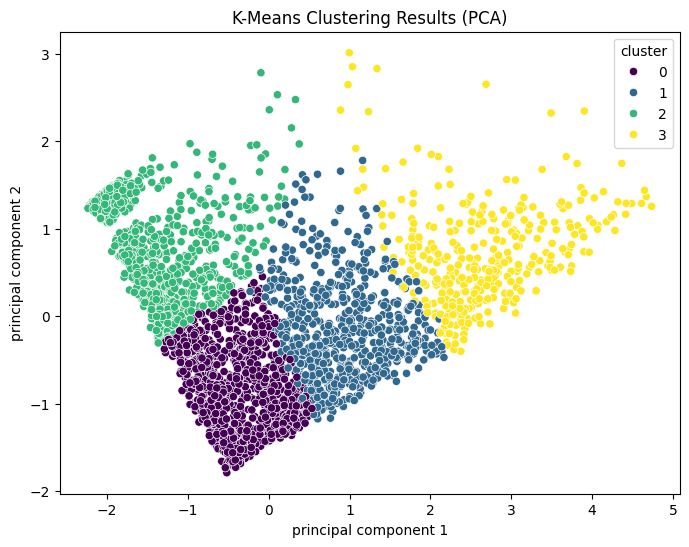

In [48]:
labels_non_outliers_df, kmeans_non_outliers_df = perform_kmeans_clustering(non_outliers_df, n_clusters=4)

Phân cụm rõ ràng ở khoảng n_cluster = 3 or 4

#### 3.2.2.3 Model Kmeans (With Log Data)

Silhouette Score: 0.34539084329397074
Calinski-Harabasz Score: 1806.4301251933161
Davies-Bouldin Score: 1.0134902234633283
Dunn Index: 0.006470691968732199


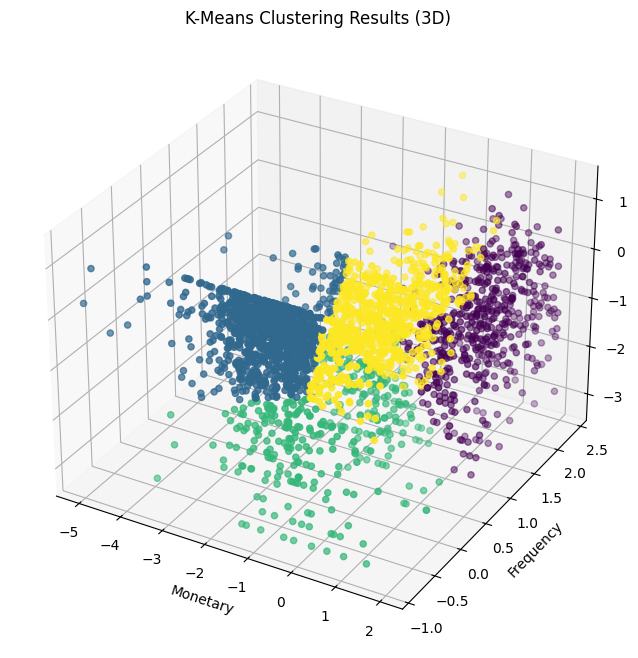

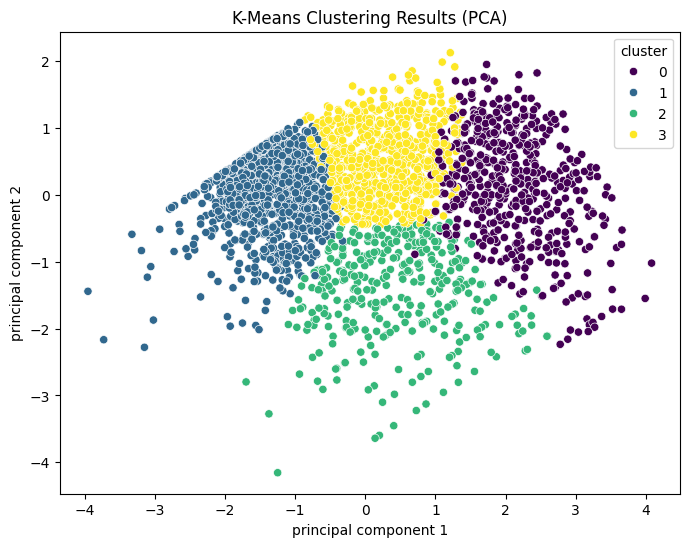

In [49]:
labels_2, kmeans_non_outliers_df_log = perform_kmeans_clustering(non_outliers_df_log, 4)

## 3.3 Model DBSCAN (With Outliers Data only)

### 3.3.1 Use Knn to know the best minpts and epsilon

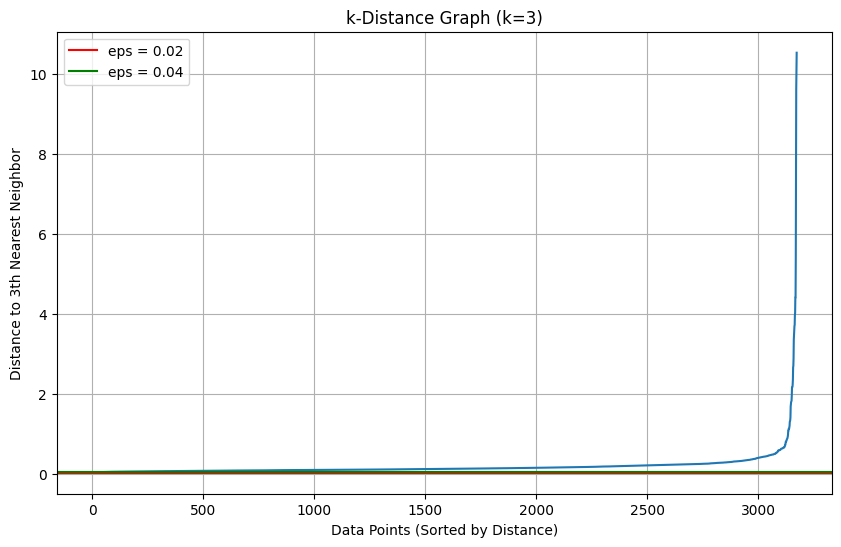

In [50]:
def plot_k_distance(data, k):
    """
    Plots the k-distance graph to help determine the optimal eps for DBSCAN.

    Args:
        data: The input DataFrame or array for clustering.
        k: The number of neighbors to consider.
    """
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Sort distances
    distances = np.sort(distances[:, k-1], axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f'k-Distance Graph (k={k})')
    plt.xlabel('Data Points (Sorted by Distance)')
    plt.ylabel(f'Distance to {k}th Nearest Neighbor')
    plt.grid(True)

    # Add vertical lines at y=0.02 and y=0.1
    plt.axhline(y=0.02, color='r', linestyle='-', label='eps = 0.02')
    plt.axhline(y=0.04, color='g', linestyle='-', label='eps = 0.04')
    plt.legend()

    plt.show()

# Example usage (replace non_outliers_df_log with your data and choose a suitable k)
# A common starting point for k is 2 * number of dimensions, or simply a small value like 5
plot_k_distance(rfm, k=3)

### 3.3.2 Model DBSCAN

Number of clusters: 4
Number of noise points: 2696
Silhouette Score (excluding noise): 0.8918518952558602
Calinski-Harabasz Score (excluding noise): 27317.734534528714
Davies-Bouldin Score (excluding noise): 0.12057151892013399


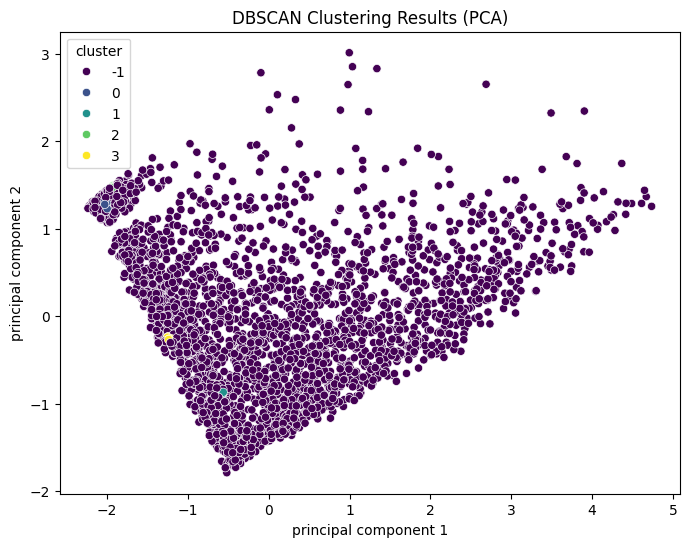

In [51]:
def perform_dbscan_clustering(data, eps, min_samples):
    """
    Performs DBSCAN clustering, evaluates the model, and visualizes the results.

    Args:
        data: The input DataFrame or array for clustering.
        eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples: The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        None (prints evaluation scores and plots the visualization).
    """
    # Build DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)

    # Evaluate the model
    # Note: Silhouette, Calinski-Harabasz, and Davies-Bouldin scores are not suitable for models with noise points (label -1)
    # We can calculate these scores on the data excluding the noise points.
    # However, for a more comprehensive evaluation, consider metrics like V-measure or Adjusted Rand Index if ground truth labels are available.

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")

    if n_clusters > 1:
        # Exclude noise points for evaluation metrics that require at least two clusters
        core_samples_mask = np.zeros_like(labels, dtype=bool)
        core_samples_mask[dbscan.core_sample_indices_] = True
        non_noise_indices = labels != -1

        if np.sum(non_noise_indices) > 1:
            silhouette = silhouette_score(data[non_noise_indices], labels[non_noise_indices])
            calinski = calinski_harabasz_score(data[non_noise_indices], labels[non_noise_indices])
            davies = davies_bouldin_score(data[non_noise_indices], labels[non_noise_indices])

            print(f"Silhouette Score (excluding noise): {silhouette}")
            print(f"Calinski-Harabasz Score (excluding noise): {calinski}")
            print(f"Davies-Bouldin Score (excluding noise): {davies}")
        else:
            print("Cannot compute evaluation scores: Not enough non-noise points for evaluation.")
    else:
        print("Cannot compute evaluation scores: Only one cluster or all points are noise.")


    # Visualize the clusters using PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    pca_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
    pca_df['cluster'] = labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=pca_df, palette='viridis', legend='full')
    plt.title('DBSCAN Clustering Results (PCA)')
    plt.show()
    return labels, dbscan

# Example usage (replace non_outliers_df_log with your data)
# You might need to adjust min_samples based on your data
labels_dbscan, dbscan = perform_dbscan_clustering(non_outliers_df, eps=0.04, min_samples=10)




## 3.4. Save Model


In [52]:
def save_model(model, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(model, file)
        print(f"Model successfully saved to {filepath}")

# Save the KMeans model
save_model(kmeans_rfm, 'kmeans_model1.pkl')
save_model(kmeans_non_outliers_df, 'kmeans_model_non_outtliers.pkl')
save_model(kmeans_non_outliers_df_log, 'kmeans_model3.pkl')
save_model(dbscan, 'dbscan_model1.pkl')

Model successfully saved to kmeans_model1.pkl
Model successfully saved to kmeans_model_non_outtliers.pkl
Model successfully saved to kmeans_model3.pkl
Model successfully saved to dbscan_model1.pkl


## => Chọn Model Kmeans 3.2.2.2 làm phân tích

# 4. Outliers Analysis

## 4.1. Đưa labels của Cluster vào non_outliers_df

In [53]:
non_outliers_data['Cluster'] = labels_non_outliers_df
non_outliers_data = non_outliers_data.sort_values(by = 'CustomerID')
non_outliers_data

CustomerID  Recency  Frequency  Monetary  Cluster
2        12348.0      121          3   1487.24        1
3        12350.0      182          1    334.40        2
4        12352.0      134          5   1561.81        3
5        12353.0       76          1     89.00        0
6        12354.0      104          1   1079.40        0
...          ...      ...        ...       ...      ...
3167     18272.0       22          3   1734.20        3
3168     18273.0      130          1     51.00        2
3169     18280.0      150          1    180.60        2
3170     18281.0       53          1     80.82        0
3172     18287.0       74          1    765.28        0

[2752 rows x 5 columns]

## 4.2 Function để biểu diễn RFM cluster dưới dạng 2d và 3d

2d để nhìn sự trồng lấn

3d để thấy tính rõ ràng

In [54]:
def plot_rfm_clusters_2d(data):
    plt.figure(figsize=(10, 6))

    colors = ['red', 'blue', 'green', 'yellow', 'purple']

    for cluster in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster]
        plt.scatter(cluster_data['Recency'],
                    cluster_data['Frequency'],
                    c=colors[cluster],
                    label=f'Cluster {cluster}',
                    alpha=0.6)

    plt.xlabel('Recency')
    plt.ylabel('Frequency')
    plt.title('Customer Segments in 2D RFM Space')
    plt.legend()
    plt.show()

def plot_rfm_clusters_3d(data):
    # Create 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create color map for clusters
    colors = ['red', 'blue', 'green', 'yellow','purple']

    # Plot each cluster
    for cluster in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster]
        ax.scatter(cluster_data['Monetary'],
                cluster_data['Frequency'],
                cluster_data['Recency'],
                c=colors[cluster],
                label=f'Cluster {cluster}',
                alpha=0.6)

    # Customize the plot
    ax.set_xlabel('Monetary')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Recency')
    ax.set_title('Customer Segments in 3D RFM Space')
    plt.legend()
    plt.show()

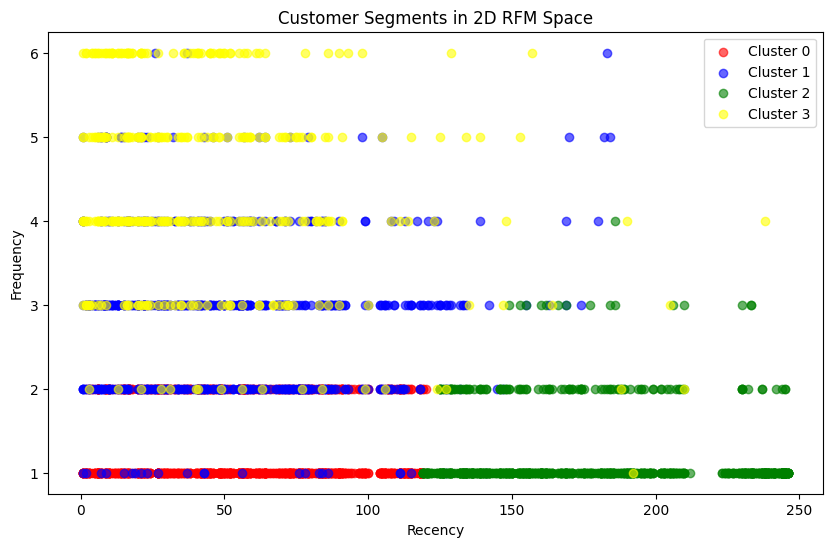

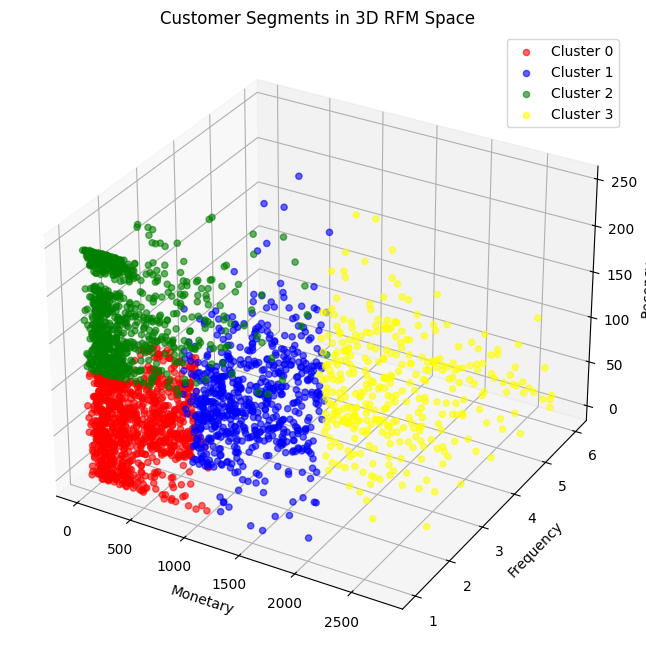

In [55]:
plot_rfm_clusters_2d(non_outliers_data)
plot_rfm_clusters_3d(non_outliers_data)

## 4.3. Tạo bảng dựa trên outliers vừa xóa đi và ghép nó vào bảng non_outliers_df

In [56]:
overlap_index = m_outliers.index.intersection(f_outliers.index)

m_o_outliers = m_outliers.drop(overlap_index)
f_o_outliers = f_outliers.drop(overlap_index)
mf_o_outliers = m_outliers.loc[overlap_index]

In [57]:
m_o_outliers['Cluster'] =  -3
f_o_outliers['Cluster'] = -2
mf_o_outliers['Cluster'] = -1

In [58]:
outliers_data = pd.concat([m_o_outliers, f_o_outliers, mf_o_outliers])
outliers_data

CustomerID  Recency  Frequency  Monetary  Cluster
0        12346.0      198          1  77183.60       -3
1        12347.0        2          5   2790.86       -3
8        12356.0      118          2   2753.08       -3
10       12359.0       62          3   3495.73       -3
16       12370.0      147          3   2806.41       -3
...          ...      ...        ...       ...      ...
3110     18172.0        6          9   4309.88       -1
3125     18198.0       30         13   4113.11       -1
3137     18223.0       15         10   3604.61       -1
3140     18226.0        7          8   3584.23       -1
3142     18229.0       10         12   4368.66       -1

[421 rows x 5 columns]

In [59]:
rfm_non_outliers = pd.concat([non_outliers_data, outliers_data])
rfm_non_outliers

CustomerID  Recency  Frequency  Monetary  Cluster
2        12348.0      121          3   1487.24        1
3        12350.0      182          1    334.40        2
4        12352.0      134          5   1561.81        3
5        12353.0       76          1     89.00        0
6        12354.0      104          1   1079.40        0
...          ...      ...        ...       ...      ...
3110     18172.0        6          9   4309.88       -1
3125     18198.0       30         13   4113.11       -1
3137     18223.0       15         10   3604.61       -1
3140     18226.0        7          8   3584.23       -1
3142     18229.0       10         12   4368.66       -1

[3173 rows x 5 columns]

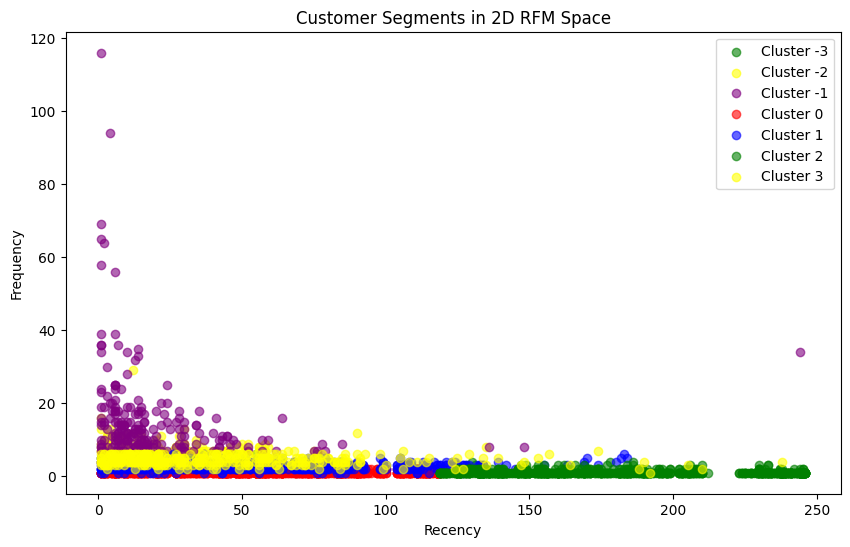

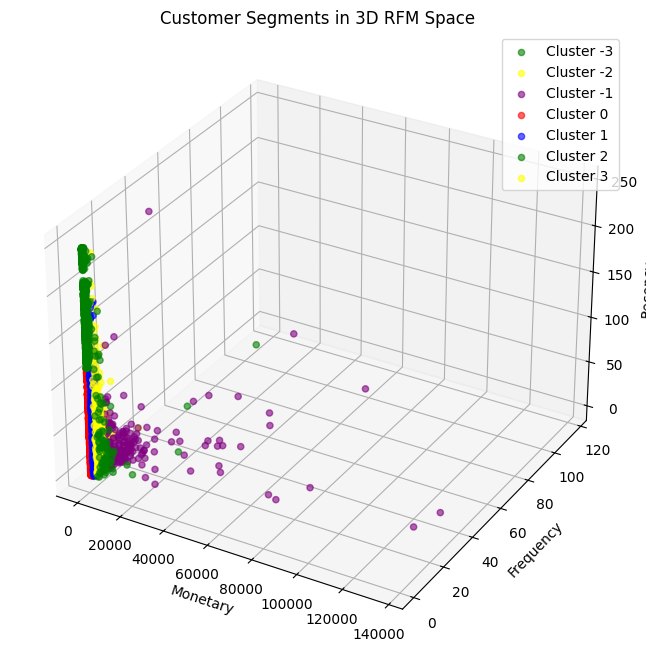

In [60]:
plot_rfm_clusters_2d(rfm_non_outliers)

plot_rfm_clusters_3d(rfm_non_outliers)


## 4.4. RFM Score

In [61]:
# divide rfm into 4 quarter to set the scorre
r_quarters = rfm_non_outliers['Recency'].quantile([0, 0.25, 0.5, 0.75, 1]).to_list()
f_quarters = rfm_non_outliers['Frequency'].quantile([0, 0.25, 0.5, 0.75, 1]).to_list()
m_quarters = rfm_non_outliers['Monetary'].quantile([0, 0.25, 0.5, 0.75, 1]).to_list()

In [62]:
quartile_spread = pd.DataFrame(
    list(zip(r_quarters, f_quarters, m_quarters)),
    columns=['R_Recency', 'F_Frequency', 'M_Monetary'],
    index=['min', 'Q1', 'Q2', 'Q3', 'max']
)
print(quartile_spread)
# F frequency có Q1 = min -> sẽ không chia được thành 4 (có thể loại bỏ duplicate rồi chia đươc bao nhiêu thì chia)

     R_Recency  F_Frequency  M_Monetary
min        1.0          1.0        2.90
Q1        24.0          1.0      254.96
Q2        62.0          2.0      534.57
Q3       129.0          3.0     1251.75
max      246.0        116.0   136028.13


In [63]:
f_quarters = pd.Series(f_quarters).drop_duplicates().to_list()

In [64]:
rfm_non_outliers['f_score'] = pd.cut(
    rfm_non_outliers['Frequency'],
    bins=f_quarters,
    labels=range(1, len(f_quarters)),
    include_lowest=True
)

In [65]:
rfm_non_outliers['r_score'] = pd.cut(rfm_non_outliers['Recency'], bins=r_quarters, labels=[4,3,2,1], include_lowest=True, duplicates='drop')

rfm_non_outliers['m_score'] = pd.cut(rfm_non_outliers['Monetary'], bins=m_quarters, labels=[1,2,3,4], include_lowest=True, duplicates='drop')
rfm_non_outliers['RFM_Score'] = rfm_non_outliers['r_score'].astype(str) + rfm_non_outliers['f_score'].astype(str) + rfm_non_outliers['m_score'].astype(str)

rfm_non_outliers['RFM_Score'].unique()

array(['224', '112', '134', '211', '213', '212', '412', '111', '324',
       '113', '114', '312', '313', '334', '434', '223', '413', '323',
       '414', '314', '234', '311', '433', '424', '333', '423', '214',
       '411', '222', '332', '122', '132', '322', '123', '232', '422',
       '233', '221', '133', '124', '121', '432', '421', '331', '431',
       '321'], dtype=object)

## 4.4. Visualize all Cluster Labels


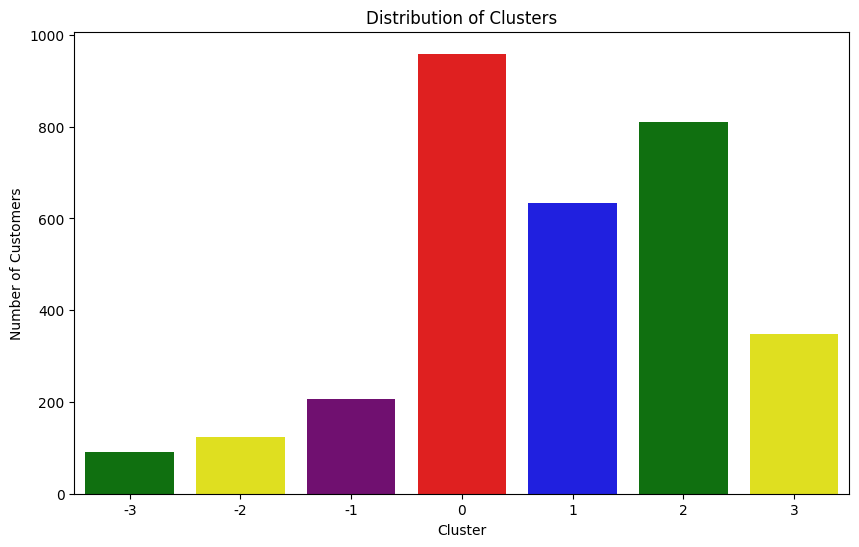

In [66]:
cluster_sizes = rfm_non_outliers['Cluster'].value_counts()
color1 = ['green', 'yellow', 'purple','red', 'blue', ]

plt.figure(figsize = (10,6))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette = color1)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Add value labels on top of each bar
# for i, v in enumerate(cluster_sizes.values):
#     plt.text(i, v, str(v), ha='center', va='bottom')
# plt.show()

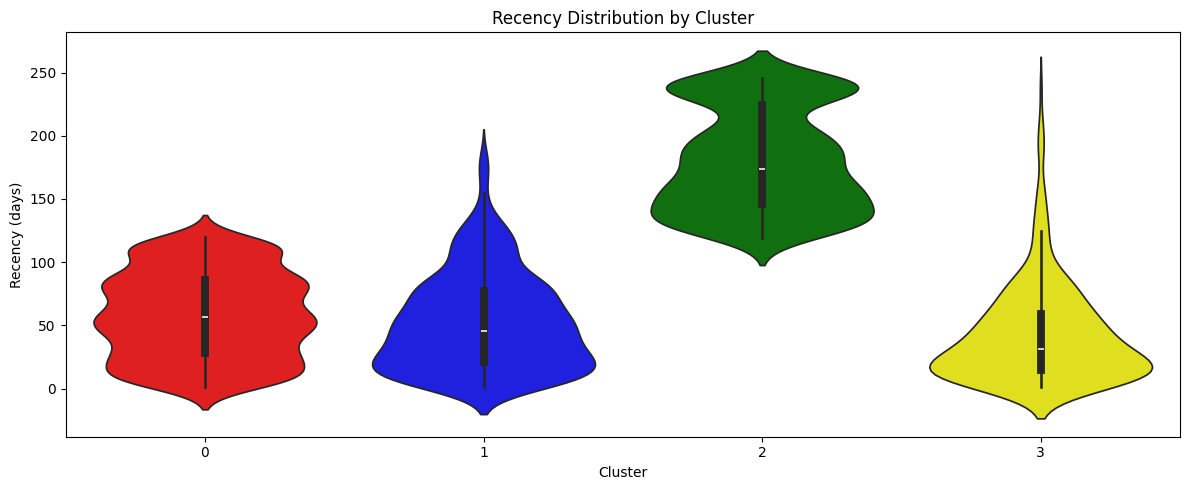

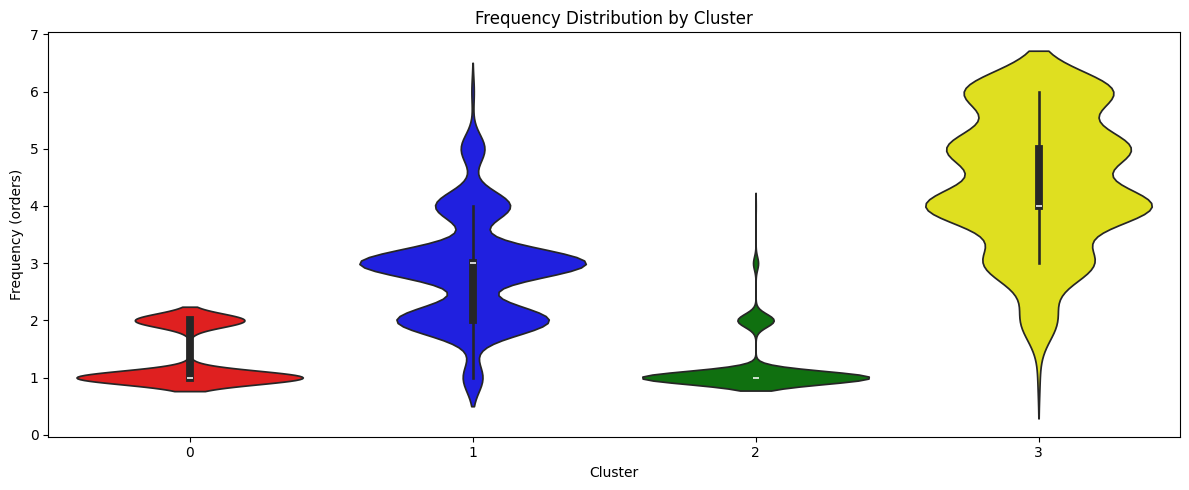

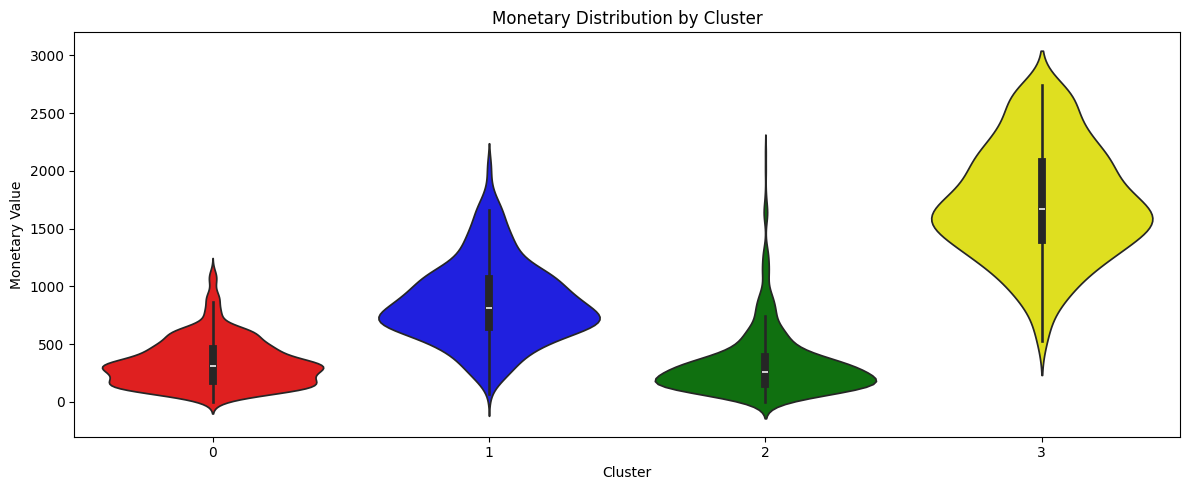

In [67]:
def plot_non_out_violin(data):
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

    # Plot Recency
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Recency', data=data, palette = ['red', 'blue', 'green', 'yellow','purple' ])
    plt.title('Recency Distribution by Cluster')
    plt.ylabel('Recency (days)')
    plt.tight_layout()
    plt.show()

    # Plot Frequency
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Frequency', data=data, palette = ['red', 'blue', 'green', 'yellow','purple' ])
    plt.title('Frequency Distribution by Cluster')
    plt.ylabel('Frequency (orders)')
    plt.tight_layout()
    plt.show()

    # Plot Monetary
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Monetary', data=data, palette = ['red', 'blue', 'green', 'yellow','purple' ])
    plt.title('Monetary Distribution by Cluster')
    plt.ylabel('Monetary Value')

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_non_out_violin(non_outliers_data)


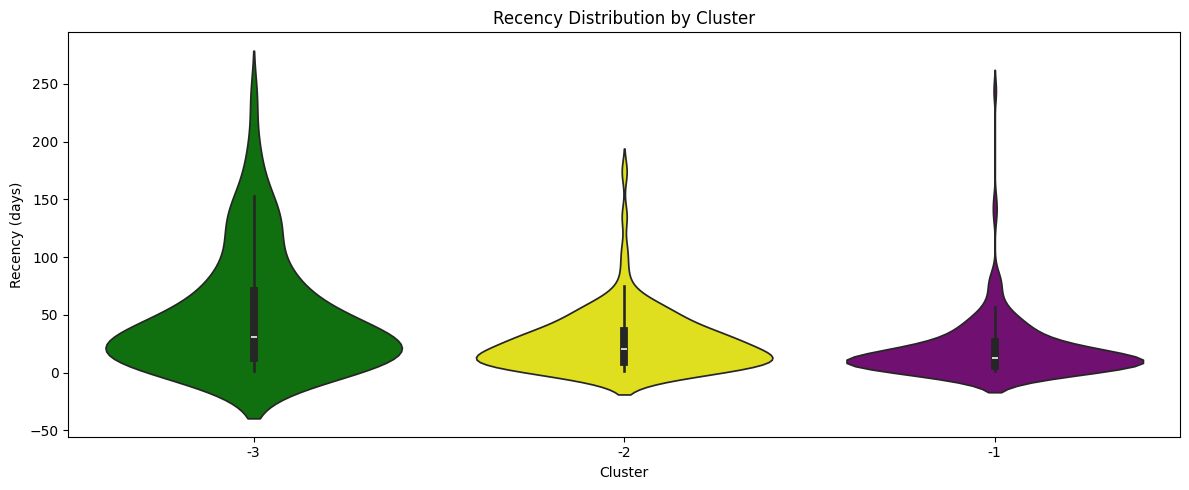

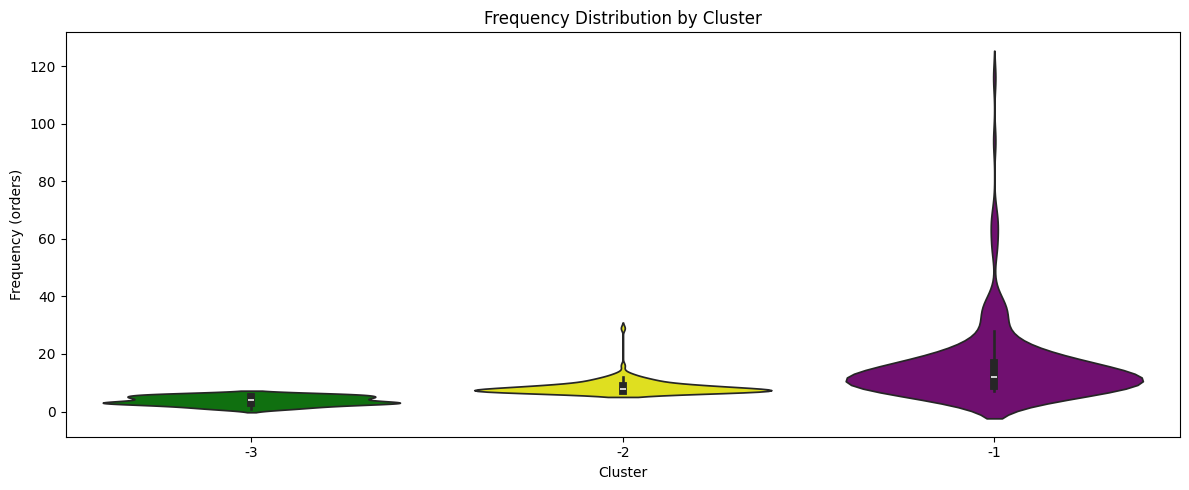

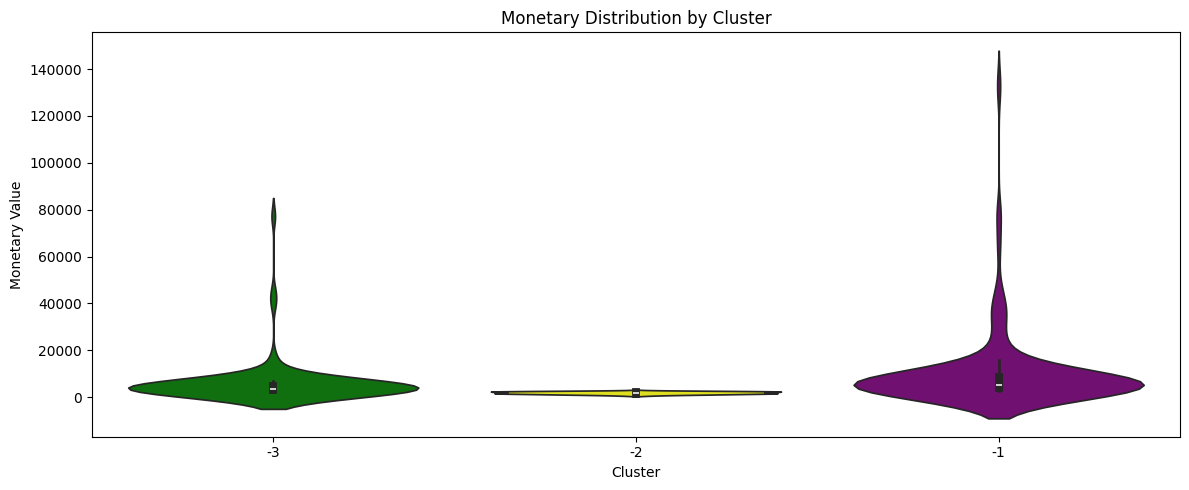

In [68]:
def plot_non_out_violin(data):
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

    # Plot Recency
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Recency', data=data, palette = ['green', 'yellow', 'purple'])
    plt.title('Recency Distribution by Cluster')
    plt.ylabel('Recency (days)')
    plt.tight_layout()
    plt.show()

    # Plot Frequency
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Frequency', data=data, palette = ['green', 'yellow', 'purple' ])
    plt.title('Frequency Distribution by Cluster')
    plt.ylabel('Frequency (orders)')
    plt.tight_layout()
    plt.show()

    # Plot Monetary
    plt.figure(figsize = (12,5))
    sns.violinplot(x='Cluster', y='Monetary', data=data, palette = ['green', 'yellow', 'purple' ])
    plt.title('Monetary Distribution by Cluster')
    plt.ylabel('Monetary Value')

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_non_out_violin(outliers_data)


# 5. Phân nhóm các khách hàng này


## 5.1. Calculate mean and median for each cluster

In [69]:
cluster_summary_mean = rfm_non_outliers.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
cluster_summary_median = rfm_non_outliers.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].median()

print("Mean values for each cluster:")
display(cluster_summary_mean)

print("\nMedian values for each cluster:")
display(cluster_summary_median)

Mean values for each cluster:


Recency  Frequency      Monetary
Cluster                                     
-3        49.586957   3.826087   5921.153707
-2        26.878049   8.495935   1849.845528
-1        20.276699  15.839806  10366.585485
 0        58.241919   1.326382    336.967780
 1        52.699842   2.875197    864.125893
 2       180.187423   1.175092    330.804451
 3        42.790831   4.415473   1728.521977


Median values for each cluster:


Recency  Frequency  Monetary
Cluster                              
-3          30.5        4.0   3648.38
-2          20.0        8.0   1865.70
-1          13.0       12.0   5057.86
 0          57.0        1.0    307.73
 1          46.0        3.0    814.04
 2         174.0        1.0    256.44
 3          31.0        4.0   1672.81

In [70]:
print("Mean values for each cluster:")
display(cluster_summary_mean)

print("\nInterpretation of Mean values:")
print("Cluster -3 (Monetary Outliers): Moderate recency, Moderate frequency, Very high monetary value.")
print("Cluster -2 (Frequency Outliers): Low recency, Very high frequency, Moderate monetary value.")
print("Cluster -1 (Monetary and Frequency Outliers): Very low recency, Extremely high frequency, Extremely high monetary value.")
print("Cluster 0: High recency, Very low frequency, Very low monetary value.")
print("Cluster 1: Low recency, High frequency, High monetary value.")
print("Cluster 2: Very high recency, Very low frequency, Very low monetary value (Inactive/Churned).")
print("Cluster 3: Moderate recency, Moderate frequency, Moderate monetary value.")

print("\nMedian values for each cluster:")
display(cluster_summary_median)

print("\nInterpretation of Median values:")
print("Cluster -3 (Monetary Outliers): Moderate recency, Moderate frequency, High monetary value.")
print("Cluster -2 (Frequency Outliers): Low recency, High frequency, Moderate monetary value.")
print("Cluster -1 (Monetary and Frequency Outliers): Very low recency, High frequency, Very high monetary value.")
print("Cluster 0: Moderate recency, Very low frequency, Very low monetary value.")
print("Cluster 1: Low recency, High frequency, High monetary value.")
print("Cluster 2: High recency, Very low frequency, Very low monetary value (Inactive/Churned).")
print("Cluster 3: Moderate recency, Moderate frequency, Moderate monetary value.")

Mean values for each cluster:


Recency  Frequency      Monetary
Cluster                                     
-3        49.586957   3.826087   5921.153707
-2        26.878049   8.495935   1849.845528
-1        20.276699  15.839806  10366.585485
 0        58.241919   1.326382    336.967780
 1        52.699842   2.875197    864.125893
 2       180.187423   1.175092    330.804451
 3        42.790831   4.415473   1728.521977


Interpretation of Mean values:
Cluster -3 (Monetary Outliers): Moderate recency, Moderate frequency, Very high monetary value.
Cluster -2 (Frequency Outliers): Low recency, Very high frequency, Moderate monetary value.
Cluster -1 (Monetary and Frequency Outliers): Very low recency, Extremely high frequency, Extremely high monetary value.
Cluster 0: High recency, Very low frequency, Very low monetary value.
Cluster 1: Low recency, High frequency, High monetary value.
Cluster 2: Very high recency, Very low frequency, Very low monetary value (Inactive/Churned).
Cluster 3: Moderate recency, Moderate frequency, Moderate monetary value.

Median values for each cluster:


Recency  Frequency  Monetary
Cluster                              
-3          30.5        4.0   3648.38
-2          20.0        8.0   1865.70
-1          13.0       12.0   5057.86
 0          57.0        1.0    307.73
 1          46.0        3.0    814.04
 2         174.0        1.0    256.44
 3          31.0        4.0   1672.81


Interpretation of Median values:
Cluster -3 (Monetary Outliers): Moderate recency, Moderate frequency, High monetary value.
Cluster -2 (Frequency Outliers): Low recency, High frequency, Moderate monetary value.
Cluster -1 (Monetary and Frequency Outliers): Very low recency, High frequency, Very high monetary value.
Cluster 0: Moderate recency, Very low frequency, Very low monetary value.
Cluster 1: Low recency, High frequency, High monetary value.
Cluster 2: High recency, Very low frequency, Very low monetary value (Inactive/Churned).
Cluster 3: Moderate recency, Moderate frequency, Moderate monetary value.


## 5.2. Assign meaningful names to clusters

In [71]:
cluster_names = {
    -1: 'Valuable Customers (Outliers)',
    -2: 'Frequent Buyers (Outliers)',
    -3: 'High-Spending Buyers (Outliers)',
    0: 'New/Single Purchase Customers',
    1: 'Engaged Customers',
    2: 'At Risk Customers',
    3: 'Moderate Engagement Customers'
}

rfm_non_outliers['Segment'] = rfm_non_outliers['Cluster'].map(cluster_names)

display(rfm_non_outliers.head())

CustomerID  Recency  Frequency  Monetary  Cluster f_score r_score m_score  \
2     12348.0      121          3   1487.24        1       2       2       4   
3     12350.0      182          1    334.40        2       1       1       2   
4     12352.0      134          5   1561.81        3       3       1       4   
5     12353.0       76          1     89.00        0       1       2       1   
6     12354.0      104          1   1079.40        0       1       2       3   

  RFM_Score                        Segment  
2       224              Engaged Customers  
3       112              At Risk Customers  
4       134  Moderate Engagement Customers  
5       211  New/Single Purchase Customers  
6       213  New/Single Purchase Customers

In [72]:


# Calculate mean RFM values for each segment
segment_rfm_mean = rfm_non_outliers.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Calculate segment counts
segment_counts = rfm_non_outliers['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']


# Merge segment counts with mean RFM values
segment_data = pd.merge(segment_counts, segment_rfm_mean, on='Segment')

# Create the treemap with additional information
fig = px.treemap(segment_data,
                 path=['Segment'],
                 values='Count',
                 color='Monetary',  # Color the segments by average Monetary value
                 hover_data=['Recency', 'Frequency', 'Monetary'],  # Show RFM values on hover
                 title='Distribution of Customers Across Segments with Average RFM Values')
fig.show()

## 5.3. Customer Segmentation

In [73]:

segment_characteristics = {
    'Nhóm': [
        'Cluster -1 (Monetary + Frequency outliers)',
        'Cluster -2 (Frequency outliers)',
        'Cluster -3 (Monetary outliers)',
        'Cluster 0',
        'Cluster 1',
        'Cluster 2',
        'Cluster 3'
    ],
    'Đặc điểm chính': [
        'Recency thấp, Frequency rất cao, Monetary rất cao',
        'Recency thấp, Frequency cao, Monetary vừa',
        'Recency thấp-vừa, Frequency trung bình, Monetary rất cao',
        'Recency thấp-vừa, Frequency thấp, Monetary thấp',
        'Recency vừa, Frequency vừa, Monetary vừa',
        'Recency cao, Frequency thấp, Monetary thấp',
        'Recency vừa, Frequency trung bình, Monetary nhỉnh hơn nhóm yếu'
    ],
    'Điểm khác biệt nổi bật': [
        'VIP số 1 (Champions) - Khách hàng giá trị nhất, mua sắm thường xuyên và chi tiêu lớn.',
        'VIP mua thường xuyên nhưng không chi tiêu lớn - Tần suất mua cao nhưng giá trị mỗi lần mua không bằng nhóm VIP số 1.',
        'VIP mua ít nhưng mỗi lần rất lớn - Chi tiêu cao nhưng tần suất mua không thường xuyên.',
        'Khách mới hoặc mua ít, gần đây - Nhóm này có thể đang trong giai đoạn đầu của vòng đời khách hàng hoặc chỉ mua một lần.',
        'Khách khá ổn định, có tương tác trung bình - Nhóm này có mức độ tương tác và giá trị trung bình.',
        'Khách sắp rời bỏ, từng mua nhưng không quay lại lâu - Đây là nhóm có nguy cơ cao không tiếp tục mua hàng.',
        'Nhóm trung gian - Không quá yếu như Cluster 0, 2 nhưng cũng chưa ổn định như Cluster 1; thường là khách cần nurturing để nâng giá trị lâu dài'
    ]
}

# Create a pandas DataFrame from the dictionary
segment_summary_table_qualitative = pd.DataFrame(segment_characteristics)

# Display the table
display(segment_summary_table_qualitative)

Nhóm  \
0  Cluster -1 (Monetary + Frequency outliers)   
1             Cluster -2 (Frequency outliers)   
2              Cluster -3 (Monetary outliers)   
3                                   Cluster 0   
4                                   Cluster 1   
5                                   Cluster 2   
6                                   Cluster 3   

                                      Đặc điểm chính  \
0  Recency thấp, Frequency rất cao, Monetary rất cao   
1          Recency thấp, Frequency cao, Monetary vừa   
2  Recency thấp-vừa, Frequency trung bình, Moneta...   
3    Recency thấp-vừa, Frequency thấp, Monetary thấp   
4           Recency vừa, Frequency vừa, Monetary vừa   
5         Recency cao, Frequency thấp, Monetary thấp   
6  Recency vừa, Frequency trung bình, Monetary nh...   

                              Điểm khác biệt nổi bật  
0  VIP số 1 (Champions) - Khách hàng giá trị nhất...  
1  VIP mua thường xuyên nhưng không chi tiêu lớn ...  
2  VIP mua ít nhưng mỗi lần rất lớn - Chi tiêu ca...  
3  Khách mới hoặc mua ít, gần đây - Nhóm này có t...  
4  Khách khá ổn định, có tương tác trung bình - N...  
5  Khách sắp rời bỏ, từng mua nhưng không quay lạ...  
6  Nhóm trung gian - Không quá yếu như Cluster 0,...

## 5.4. XGBoost Classifier (chạy cho vui)

### 5.4.1 Test for all Classification Model

In [74]:
!pip install xgboost

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder



In [96]:
rfm_non_outliers

CustomerID  Recency  Frequency  Monetary  Cluster f_score r_score  \
2        12348.0      121          3   1487.24        1       2       2   
3        12350.0      182          1    334.40        2       1       1   
4        12352.0      134          5   1561.81        3       3       1   
5        12353.0       76          1     89.00        0       1       2   
6        12354.0      104          1   1079.40        0       1       2   
...          ...      ...        ...       ...      ...     ...     ...   
3110     18172.0        6          9   4309.88       -1       3       4   
3125     18198.0       30         13   4113.11       -1       3       3   
3137     18223.0       15         10   3604.61       -1       3       4   
3140     18226.0        7          8   3584.23       -1       3       4   
3142     18229.0       10         12   4368.66       -1       3       4   

     m_score RFM_Score                        Segment         Cluster_Name  
2          4       224              Engaged Customers         05_promising  
3          2       112              At Risk Customers      06_low_priority  
4          4       134  Moderate Engagement Customers  04_lost_loyal_large  
5          1       211  New/Single Purchase Customers      06_low_priority  
6          3       213  New/Single Purchase Customers         05_promising  
...      ...       ...                            ...                  ...  
3110       4       434  Valuable Customers (Outliers)       02_loyal_large  
3125       4       334  Valuable Customers (Outliers)       02_loyal_large  
3137       4       434  Valuable Customers (Outliers)       02_loyal_large  
3140       4       434  Valuable Customers (Outliers)       02_loyal_large  
3142       4       434  Valuable Customers (Outliers)       02_loyal_large  

[3173 rows x 11 columns]

In [ ]:
non_

In [77]:
def xgb_function(data):
  xgb_df = data.copy()

  le = LabelEncoder()
  xgb_df['Segment'] = le.fit_transform(xgb_df['Segment'])

  X_xgb = xgb_df.drop(columns=['Cluster', 'CustomerID', 'Segment'])
  y_xgb = xgb_df['Segment']

  X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

  scaler = StandardScaler()
  X_xgb_train = scaler.fit_transform(X_xgb_train)
  X_xgb_test = scaler.transform(X_xgb_test)

  return X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test, scaler

X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test, scaler_xgb = xgb_function(rfm_non_outliers)

In [78]:
def classifier_model(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print("Model name:", type(model).__name__)
  print(classification_report(y_test, y_pred))
  # print('Confusion_matrix:', confusion_matrix(y, y_pred))
  return model

In [79]:
#knn use function
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model = classifier_model(knn_model, X_xgb_train, y_xgb_train, X_xgb_test, y_xgb_test)

#logi
logi_model = LogisticRegression(random_state=42)
logi_model = classifier_model(logi_model, X_xgb_train, y_xgb_train, X_xgb_test, y_xgb_test)

#decision tree
dt_model = DecisionTreeClassifier()
dt_model = classifier_model(dt_model, X_xgb_train, y_xgb_train, X_xgb_test, y_xgb_test)

#random forest
rdf_model = RandomForestClassifier()
rdf_model = classifier_model(rdf_model, X_xgb_train, y_xgb_train, X_xgb_test, y_xgb_test)

#xgboost
xgb_model = XGBClassifier()
xgb_model = classifier_model(xgb_model, X_xgb_train, y_xgb_train, X_xgb_test, y_xgb_test)

Model name: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       166
           1       0.86      0.89      0.87       122
           2       0.92      0.81      0.86        27
           3       0.90      0.56      0.69        16
           4       0.76      0.83      0.79        60
           5       0.98      0.97      0.98       200
           6       0.95      0.93      0.94        44

    accuracy                           0.93       635
   macro avg       0.91      0.86      0.87       635
weighted avg       0.93      0.93      0.93       635

Model name: LogisticRegression
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       166
           1       0.76      0.85      0.81       122
           2       0.96      1.00      0.98        27
           3       1.00      0.62      0.77        16
           4       0.74      0.75      0.74        60
           5  

### 5.4.2 Stream lit API

In [80]:
# save model and scaler
import joblib
file_name = 'xgb_model.joblib'
filename_scaler = 'Standard_scaler.joblib'

joblib.dump(xgb_model, file_name)
joblib.dump(scaler_xgb, filename_scaler)

['Standard_scaler.joblib']

In [81]:
! pip install streamlit
! pip install ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 30.8 MB/s eta 0:00:00


In [82]:
# import streamlit as st
# import joblib
# from ngrok import ngrok

# # The image provided shows the R_score, F_score, and M_score. These scores
# # are typically calculated by binning the Recency, Frequency, and Monetary
# # values into quartiles. The code below assumes some hardcoded thresholds
# # for demonstration. You should replace these with the actual quartile
# # values from your training data.
# RECENCY_QUARTILES = [30, 90, 180, 365]
# FREQUENCY_QUARTILES = [1, 5, 10, 20]
# MONETARY_QUARTILES = [100, 500, 1500, 5000]

# def calculate_rfm_scores(recency: float, frequency: float, monetary: float) -> tuple:
#     # Reverse scoring for Recency: lower value = higher score
#     r_score = 4
#     if recency > RECENCY_QUARTILES[2]:
#         r_score = 1
#     elif recency > RECENCY_QUARTILES[1]:
#         r_score = 2
#     elif recency > RECENCY_QUARTILES[0]:
#         r_score = 3

#     # Normal scoring for Frequency and Monetary: higher value = higher score
#     f_score = 1
#     if frequency > FREQUENCY_QUARTILES[0]:
#         f_score = 2
#     if frequency > FREQUENCY_QUARTILES[1]:
#         f_score = 3
#     if frequency > FREQUENCY_QUARTILES[2]:
#         f_score = 4

#     m_score = 1
#     if monetary > MONETARY_QUARTILES[0]:
#         m_score = 2
#     if monetary > MONETARY_QUARTILES[1]:
#         m_score = 3
#     if monetary > MONETARY_QUARTILES[2]:
#         m_score = 4

#     return r_score, f_score, m_score

# # --- Main Streamlit Application ---

# st.title("Customer Segmentation Prediction App")
# st.write("This application uses your trained RFM model to predict a customer's segment. "
#          "Please ensure you have the `scaler.joblib` and `model.joblib` files in the same directory.")

# # Check for and load the saved model and scaler
# try:
#     # Load the trained scaler and model
#     scaler = joblib.load('scaler.joblib')
#     model = joblib.load('model.joblib')
#     st.sidebar.success("Model and Scaler loaded successfully!")
#     model_loaded = True
# except FileNotFoundError:
#     st.error("Error: `scaler.joblib` or `model.joblib` not found. "
#              "Please ensure your trained model files are in the same directory as this script.")
#     st.stop()
# except Exception as e:
#     st.error(f"An error occurred while loading the model files: {e}")
#     st.stop()

# st.header("Enter Customer RFM Data")
# st.write("Please provide the following customer metrics to get a segment prediction:")

# # Create input widgets for user to enter data
# col1, col2, col3 = st.columns(3)
# with col1:
#     recency = st.number_input("Recency (Days since last purchase)", min_value=1, value=90)
# with col2:
#     frequency = st.number_input("Frequency (Total transactions)", min_value=1, value=5)
# with col3:
#     monetary = st.number_input("Monetary (Total spend)", min_value=10.0, value=500.0)

# # The predict button
# if st.button("Predict Segment"):
#     # Calculate the RFM scores based on the user's input
#     r_score, f_score, m_score = calculate_rfm_scores(recency, frequency, monetary)

#     st.subheader("Calculated RFM Scores")
#     st.write(f"R-Score: `{r_score}` | F-Score: `{f_score}` | M-Score: `{m_score}`")

#     # Create a DataFrame for prediction
#     # The model expects a 2D array, so we use reshape(-1, 1) or pass a list of lists.
#     # The feature order must be the same as the training data: [r_score, f_score, m_score]
#     user_data = np.array([[r_score, f_score, m_score]])

#     # Transform the user data using the loaded scaler
#     scaled_user_data = scaler.transform(user_data)

#     # Make the prediction
#     prediction = model.predict(scaled_user_data)

#     # Display the result
#     st.header("Predicted Customer Segment")
#     if prediction[0] == 0:
#         st.success("The predicted segment is: **'At Risk Customers'**")
#     elif prediction[0] == 1:
#         st.success("The predicted segment is: **'Valuable Customers (Outliers)'**")
#     elif prediction[0] == 2:
#         st.success("The predicted segment is: **'Moderate Engagement Customers'**")
#     elif prediction[0] == 3:
#         st.success("The predicted segment is: **'Engaged Customers'**")
#     else:
#         st.warning("Prediction result is outside of known segments.")

#     st.write("---")
#     st.write("The model made this prediction based on the input RFM scores. "
#              "The segment names are based on common RFM analysis categories.")



In [97]:
! wget -q -O - ipv4.icanhazip.com

34.139.86.150


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501


⠙⠹⠸

⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.139.86.150:8501

⠼⠴⠦⠧⠇⠏your url is: https://common-banks-brake.loca.lt


# 6. Cluster Analysis & Profiling

## 6.1. Phân tích đặc điểm nhân khẩu học

In [85]:
df_with_clusters = pd.merge(df, rfm_non_outliers[['CustomerID', 'Cluster', 'Segment']], on='CustomerID', how='left')

# Group by Segment and Country and count customers
segment_country_distribution = df_with_clusters.groupby(['Segment', 'Country'])['CustomerID'].nunique().reset_index()
segment_country_distribution.columns = ['Segment', 'Country', 'CustomerCount']

# Calculate the total number of customers in each segment
total_customers_per_segment = segment_country_distribution.groupby('Segment')['CustomerCount'].sum().reset_index()
total_customers_per_segment.columns = ['Segment', 'TotalCustomers']

# Merge to calculate the percentage
segment_country_distribution = pd.merge(segment_country_distribution, total_customers_per_segment, on='Segment')
segment_country_distribution['Percentage'] = (segment_country_distribution['CustomerCount'] / segment_country_distribution['TotalCustomers']) * 100

# Display the distribution for each segment
for segment in segment_country_distribution['Segment'].unique():
    print(f"Distribution for {segment}:")
    display(segment_country_distribution[segment_country_distribution['Segment'] == segment].sort_values(by='Percentage', ascending=False).head().drop(columns=['Segment']))
    print("\n")

Distribution for At Risk Customers:


Country  CustomerCount  TotalCustomers  Percentage
19  United Kingdom            742             811   91.491985
7           France             16             811    1.972873
8          Germany             11             811    1.356350
10           Italy              5             811    0.616523
14        Portugal              5             811    0.616523



Distribution for Engaged Customers:


Country  CustomerCount  TotalCustomers  Percentage
39  United Kingdom            573             634   90.378549
27         Germany             12             634    1.892744
26          France             10             634    1.577287
22         Belgium              7             634    1.104101
20       Australia              3             634    0.473186



Distribution for Frequent Buyers (Outliers):


Country  CustomerCount  TotalCustomers  Percentage
45  United Kingdom            117             123   95.121951
43         Germany              3             123    2.439024
41         Belgium              1             123    0.813008
42          France              1             123    0.813008
44           Italy              1             123    0.813008



Distribution for High-Spending Buyers (Outliers):


Country  CustomerCount  TotalCustomers  Percentage
61  United Kingdom             59              94   62.765957
53         Germany              9              94    9.574468
60     Switzerland              4              94    4.255319
55           Japan              3              94    3.191489
52          France              2              94    2.127660



Distribution for Moderate Engagement Customers:


Country  CustomerCount  TotalCustomers  Percentage
77  United Kingdom            310             351   88.319088
67          France             11             351    3.133903
68         Germany             10             351    2.849003
63         Belgium              4             351    1.139601
74           Spain              4             351    1.139601



Distribution for New/Single Purchase Customers:


Country  CustomerCount  TotalCustomers  Percentage
97  United Kingdom            885             959   92.283629
85          France             17             959    1.772680
86         Germany             16             959    1.668405
93           Spain              8             959    0.834202
80         Belgium              6             959    0.625652



Distribution for Valuable Customers (Outliers):


Country  CustomerCount  TotalCustomers  Percentage
110  United Kingdom            182             207   87.922705
103          France              7             207    3.381643
104         Germany              7             207    3.381643
99        Australia              2             207    0.966184
101            EIRE              2             207    0.966184

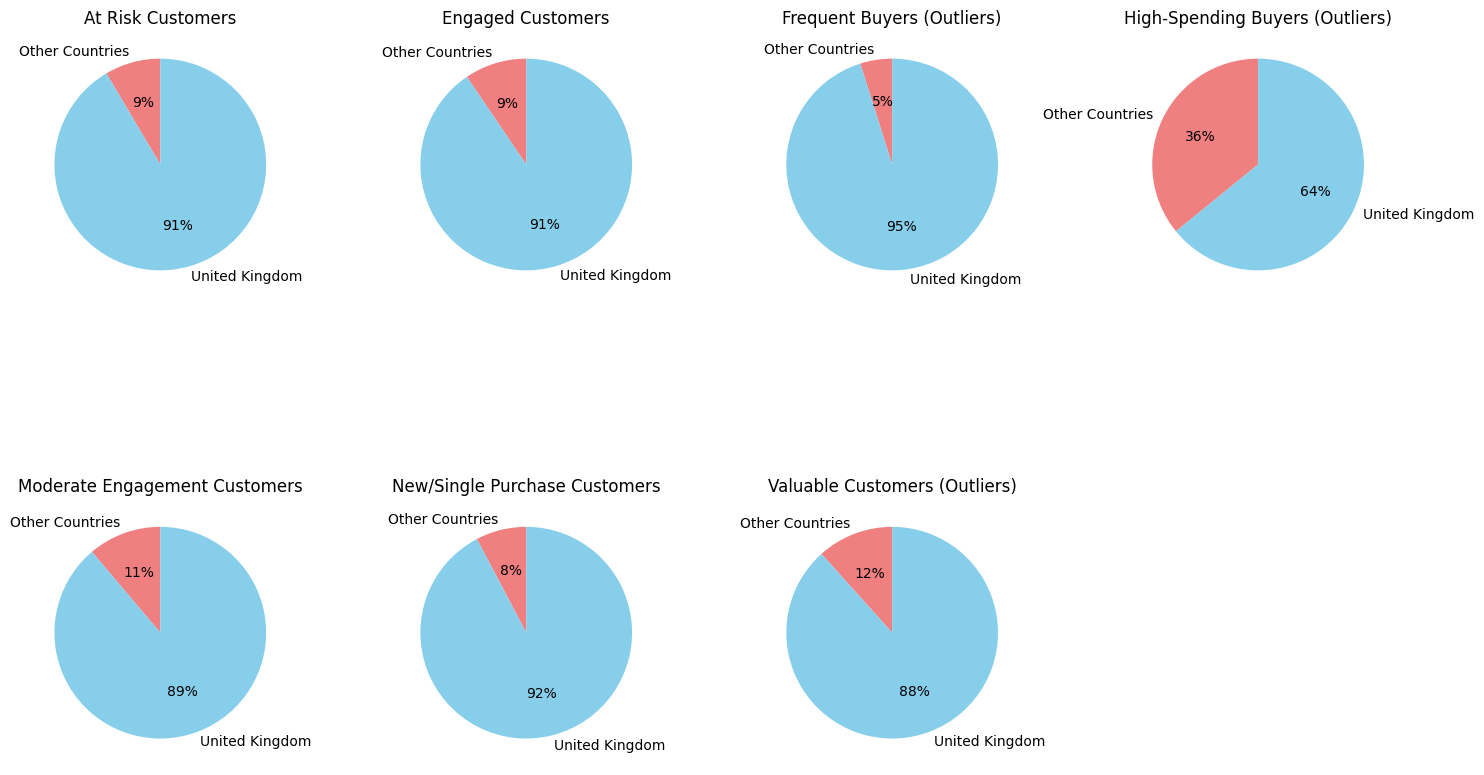

In [86]:
# Categorize countries into UK and Non-UK
df_with_clusters['Country_Category'] = df_with_clusters['Country'].apply(lambda x: 'United Kingdom' if x == 'United Kingdom' else 'Other Countries')

# Group by Segment and Country_Category and count customers
uk_nonuk_distribution = df_with_clusters.groupby(['Segment', 'Country_Category'])['CustomerID'].nunique().reset_index()
uk_nonuk_distribution.columns = ['Segment', 'Country_Category', 'CustomerCount']

# Plotting pie charts for each segment
segments = sorted(uk_nonuk_distribution['Segment'].unique())
num_segments = len(segments)

# Determine the grid layout (3 then 4)
nrows = 2 if num_segments > 3 else 1
ncols1 = 3 if num_segments > 3 else num_segments
ncols2 = num_segments - ncols1 if num_segments > 3 else 0
fig, axes = plt.subplots(nrows, max(ncols1, ncols2) if num_segments > 3 else ncols1, figsize=(15, nrows * 5))
axes = axes.flatten() if nrows > 1 else [axes] # Ensure axes is always an iterable

# Define consistent colors for UK and Other Countries
colors = {'United Kingdom': 'skyblue', 'Other Countries': 'lightcoral'}

for i, segment in enumerate(segments):
    ax = axes[i]
    segment_data = uk_nonuk_distribution[uk_nonuk_distribution['Segment'] == segment]

    # Ensure both categories are present even if count is 0 for a segment
    # This is important for consistent pie chart structure and colors
    for category in colors.keys():
        if category not in segment_data['Country_Category'].values:
            segment_data = segment_data.append({'Segment': segment, 'Country_Category': category, 'CustomerCount': 0}, ignore_index=True)

    # Sort by category name for consistent color mapping order
    segment_data = segment_data.sort_values(by='Country_Category')


    # Plot pie chart with consistent colors
    ax.pie(segment_data['CustomerCount'],
           labels=segment_data['Country_Category'],
           autopct='%1.0f%%',
           startangle=90,
           colors=[colors[cat] for cat in segment_data['Country_Category']])
    ax.set_title(f'{segment}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 6.2. Buying Behavior

Analyze customer behavior using time-based features, then analyze popular products and purchase times for each cluster by grouping and aggregation.

In [87]:
# Merge cluster information with the original dataframe 'df' again to ensure 'IsCancelled' is available
df_with_clusters = pd.merge(df, rfm_non_outliers[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# Identify cancelled orders in the original dataframe and add as a column
df_with_clusters['IsCancelled'] = (df_with_clusters['Quantity'] < 0) | (df_with_clusters['InvoiceNo'].astype(str).str.startswith('C'))


# 1. Extract time-based features
df_with_clusters['Hour'] = df_with_clusters['InvoiceDate'].dt.hour
df_with_clusters['DayOfWeek'] = df_with_clusters['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
df_with_clusters['Month'] = df_with_clusters['InvoiceDate'].dt.month

In [88]:
# 2. For each cluster, determine the most frequent product descriptions.
# Filter out cancelled orders before analyzing popular products
df_purchases = df_with_clusters[~df_with_clusters['IsCancelled']].copy()

popular_products_per_cluster = df_purchases.groupby(['Cluster', 'Description']).size().reset_index(name='Count')

# Display the top N descriptions for each cluster in separate tables
top_n = 5
print(f"Top {top_n} Popular Products per Cluster:")
for cluster in sorted(popular_products_per_cluster['Cluster'].unique()):
    # Use segment names in titles
    segment_name = cluster_names.get(cluster, f'Cluster {int(cluster)}')
    print(f"\n{segment_name}:")
    cluster_top_products = popular_products_per_cluster[popular_products_per_cluster['Cluster'] == cluster].nlargest(top_n, 'Count')
    display(cluster_top_products)

Top 5 Popular Products per Cluster:

High-Spending Buyers (Outliers):


Cluster               Description  Count
1506     -3.0  REGENCY CAKESTAND 3 TIER     69
1266     -3.0             PARTY BUNTING     50
1406     -3.0                   POSTAGE     50
1051     -3.0   LUNCH BAG RED RETROSPOT     47
959      -3.0   JUMBO BAG RED RETROSPOT     45


Frequent Buyers (Outliers):


Cluster                         Description  Count
4432     -2.0  WHITE HANGING HEART T-LIGHT HOLDER    148
3564     -2.0                       PARTY BUNTING     99
3319     -2.0             LUNCH BAG RED RETROSPOT     81
2236     -2.0       ASSORTED COLOUR BIRD ORNAMENT     79
4471     -2.0   WOODEN PICTURE FRAME WHITE FINISH     78


Valuable Customers (Outliers):


Cluster                         Description  Count
6612     -1.0            REGENCY CAKESTAND 3 TIER    369
5859     -1.0             JUMBO BAG RED RETROSPOT    355
7299     -1.0  WHITE HANGING HEART T-LIGHT HOLDER    346
5991     -1.0             LUNCH BAG RED RETROSPOT    284
6298     -1.0                       PARTY BUNTING    276


New/Single Purchase Customers:


Cluster                         Description  Count
9980      0.0  WHITE HANGING HEART T-LIGHT HOLDER    170
9061      0.0                       PARTY BUNTING    138
9343      0.0            REGENCY CAKESTAND 3 TIER    119
9380      0.0        REX CASH+CARRY JUMBO SHOPPER     97
7577      0.0       ASSORTED COLOUR BIRD ORNAMENT     93


Engaged Customers:


Cluster                         Description  Count
12779      1.0  WHITE HANGING HEART T-LIGHT HOLDER    230
12110      1.0            REGENCY CAKESTAND 3 TIER    197
10259      1.0       ASSORTED COLOUR BIRD ORNAMENT    175
11813      1.0                       PARTY BUNTING    170
11665      1.0     NATURAL SLATE HEART CHALKBOARD     130


At Risk Customers:


Cluster                         Description  Count
15229      2.0  WHITE HANGING HEART T-LIGHT HOLDER    134
14673      2.0            REGENCY CAKESTAND 3 TIER     87
14283      2.0     NATURAL SLATE HEART CHALKBOARD      78
13051      2.0       ASSORTED COLOUR BIRD ORNAMENT     74
13971      2.0               HEART OF WICKER SMALL     74


Moderate Engagement Customers:


Cluster                         Description  Count
18025      3.0  WHITE HANGING HEART T-LIGHT HOLDER    242
17343      3.0            REGENCY CAKESTAND 3 TIER    198
17034      3.0                       PARTY BUNTING    182
16741      3.0             LUNCH BAG RED RETROSPOT    155
16615      3.0             JUMBO BAG RED RETROSPOT    150

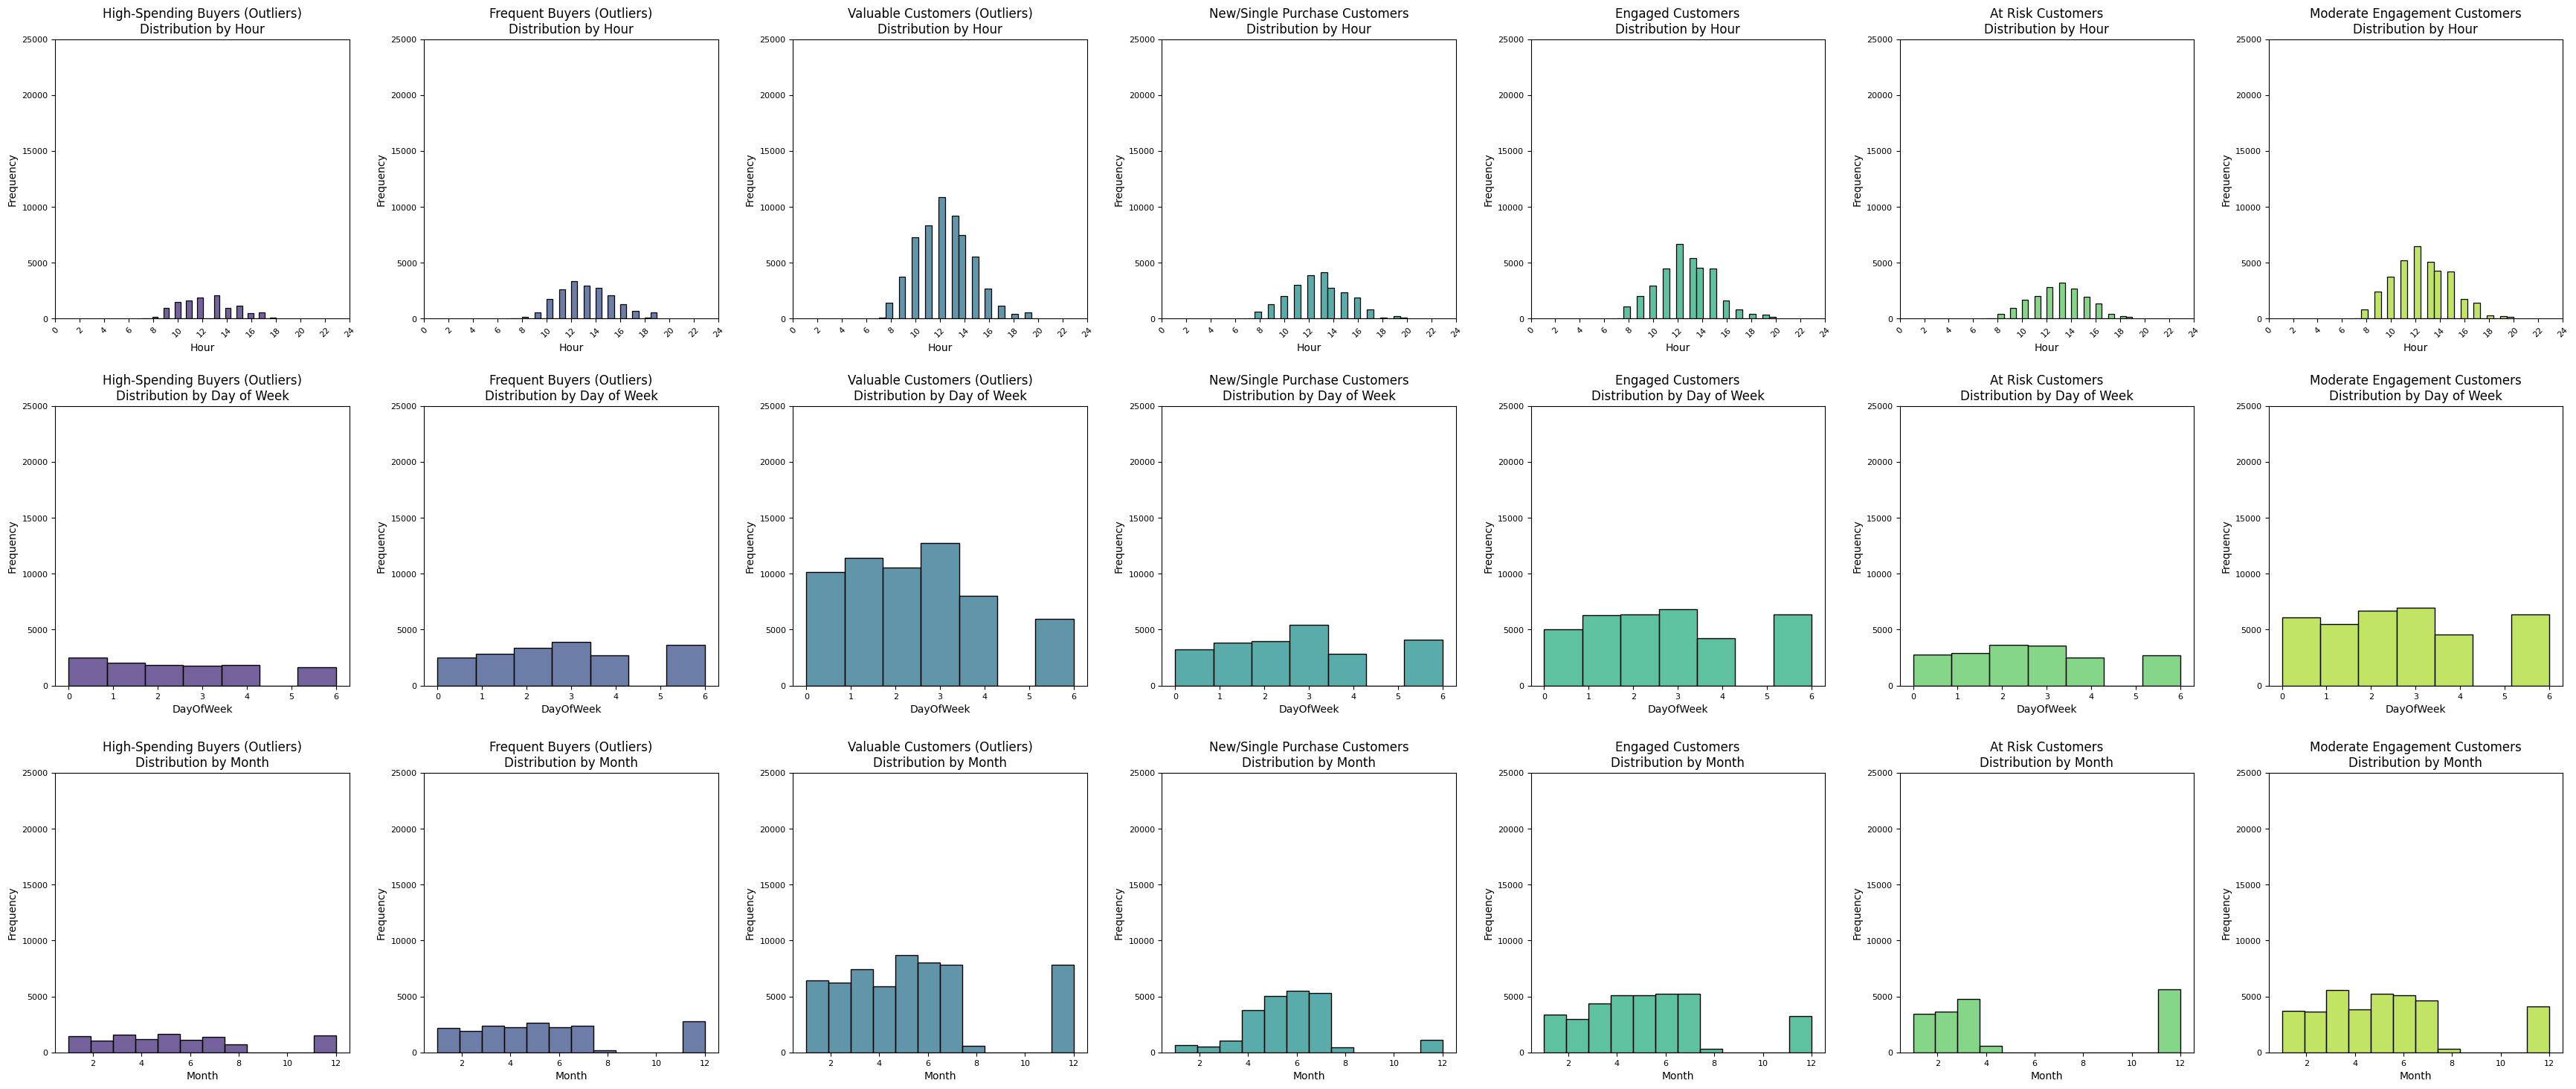

In [89]:
# Get unique clusters for plotting, exclude NaN
clusters = sorted([c for c in df_purchases['Cluster'].unique() if pd.notna(c)])
num_clusters = len(clusters)

# Define the timing features
timing_features = ['Hour', 'DayOfWeek', 'Month']
timing_titles = ['Distribution by Hour', 'Distribution by Day of Week', 'Distribution by Month']
timing_bins = [24, 7, 12] # Number of bins for each feature

# Create a figure and axes for the grid of plots - Reverted to previous size
fig, axes = plt.subplots(len(timing_features), num_clusters, figsize=(num_clusters * 5, len(timing_features) * 5)) # Increased figure size


for i, feature in enumerate(timing_features):
    for j, cluster in enumerate(clusters):
        ax = axes[i, j]
        cluster_data = df_purchases[df_purchases['Cluster'] == cluster]

        sns.histplot(data=cluster_data, x=feature, bins=timing_bins[i], ax=ax, color=sns.color_palette('viridis', num_clusters)[j])

        # Use segment names in titles
        segment_name = cluster_names.get(cluster, f'Cluster {int(cluster)}')
        ax.set_title(f'{segment_name}\n{timing_titles[i]}') # Added newline for better spacing
        ax.set_xlabel(feature) # Reverted x-label font size
        ax.set_ylabel('Frequency') # Reverted y-label font size
        ax.tick_params(axis='x', labelsize=8) # Reverted x-axis tick font size
        ax.tick_params(axis='y', labelsize=8) # Reverted y-axis tick font size


        if feature == 'Hour':
            # Set x-ticks to exclude specified hours
            hours_to_keep = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
            ax.set_xticks(hours_to_keep)
            ax.tick_params(axis='x', rotation=45) # Keep rotation for Hour


        # Set common y-axis limit for all plots in this row
        ax.set_ylim(0, 25000) # Keep the fixed y-axis limit

plt.tight_layout(pad=2.0) # Increased padding between subplots
plt.show()

## 6.3. Analyzing Order Value
Let's examine the average/median value of each order within each cluster (in addition to the existing Monetary value).

**Reasoning**:
Calculate the total value of each order and filter for valid purchases to analyze the average and median order value per cluster.


In [90]:
# Calculate order value for each row
df_with_clusters['OrderValue'] = df_with_clusters['Quantity'] * df_with_clusters['UnitPrice']

# Filter out cancelled orders
df_purchases_valid = df_with_clusters[(df_with_clusters['Quantity'] > 0) & (~df_with_clusters['InvoiceNo'].astype(str).str.startswith('C'))].copy()

# Merge segment information into df_with_clusters
df_purchases_valid = pd.merge(df_purchases_valid, rfm_non_outliers[['CustomerID', 'Segment']], on='CustomerID', how='left')

# Group by Segment and calculate mean and median OrderValue
segment_ordervalue_summary = df_purchases_valid.groupby('Segment')['OrderValue'].agg(['mean', 'median']).reset_index()

# Display the summary table with left-aligned segment names
print("Mean and Median Order Value per Segment:")
display(segment_ordervalue_summary.style.set_properties(**{'text-align': 'left'}))

Mean and Median Order Value per Segment:


## 6.4. Summarizing Information and Customer Cluster Profiles
Based on the analysis of RFM metrics, demographics (Country), shopping behavior (Popular Products, Purchase Time), Order Value (Average/Median), and Cancellation Rate, we can build detailed profiles for each customer cluster as follows:

    1. Cluster -1: Most Valuable Customers (Outliers)

RFM: Very low Recency, very high Frequency, and very high Monetary value. This is the group with the highest spending and most frequent recent purchases.

Demographics: Predominantly from the UK (approx. 90%), with a smaller portion from other countries like Germany and France.

Shopping Behavior: Purchases a wide variety of products at a high frequency. Popular products include JUMBO BAG RED RETROSPOT, WHITE HANGING HEART T-LIGHT HOLDER, and REGENCY CAKESTAND 3 TIER. Shopping is spread across all days of the week and hours of the day, with a peak during midweek and business hours. The average/median order value is significantly higher than non-outlier groups.

General Profile: This group represents "Champions" or "VIPs." They are the highest revenue generators and have the most active engagement. However, their cancellation rate also needs attention.

    2. Cluster -2: Frequent Buyers (Outliers)

RFM: Low Recency, very high Frequency, and moderate Monetary value. They shop very frequently, but the value of each order is not excessively high.

Demographics: Almost entirely from the UK (approx. 98%).

Shopping Behavior: High purchase frequency with a diverse range of products. Popular products are similar to Cluster -1 but also include RED HANGING HEART T-LIGHT HOLDER and RED RETROSPOT CHARLOTTE BAG. Shopping is concentrated in the middle of the week and during business hours. The average/median order value is moderate.

General Profile: A highly loyal and engaged customer group, but their spending per purchase is not as high as Group -1. Their low cancellation rate is a key strength.

    3. Cluster -3: High-Spending Buyers (Outliers)

RFM: Low to moderate Recency, average Frequency, and very high Monetary value. They don't shop very often, but each purchase has a very high value.

Demographics: Majority from the UK (approx. 71%), with a higher proportion from other countries compared to other outlier clusters (Germany, France, Switzerland, Spain).

Shopping Behavior: Purchase frequency is not as high as groups -1 and -2, but the average/median order value is very high. Popular products are similar to other outlier clusters. Shopping is spread evenly across all days and hours.

General Profile: The "Big Spenders." They generate significant revenue but lack purchase regularity and have an alarmingly high cancellation rate.

    4. Cluster 0: New/Single Purchase Customers

RFM: Low to moderate Recency, very low Frequency (usually 1), and very low Monetary value.

Demographics: Predominantly from the UK (approx. 92%).

Shopping Behavior: Typically make only 1-2 low-value purchases. Popular products include WHITE HANGING HEART T-LIGHT HOLDER, REX CASH+CARRY JUMBO SHOPPER. Shopping is concentrated midweek during business hours. The average/median order value is very low.

General Profile: A group of potential customers that need to be nurtured to become loyal customers.

    5. Cluster 1: Engaged Customers

RFM: Low Recency, high Frequency, and high Monetary value (but lower than the outlier groups). They shop quite often and have good spending habits.

Demographics: Majority from the UK (approx. 91%).

Shopping Behavior: Frequent purchases with a moderate average/median order value. Popular products are similar to other high-value groups. Shopping is concentrated midweek during business hours.

General Profile: The "Loyal Customers." They are the backbone of regular sales and should be kept satisfied.

    6. Cluster 2: At-Risk Customers

RFM: Very high Recency, very low Frequency, and very low Monetary value. They have not shopped for a long time.

Demographics: Majority from the UK (approx. 91%).

Shopping Behavior: Low interaction, with low average/median order value. Popular products are similar to other low-value groups. Shopping times are more spread out compared to the active groups.

General Profile: This group requires urgent re-engagement campaigns.

    7. Cluster 3: Moderate Engagement Customers

RFM: Moderate Recency, average Frequency, and average Monetary value.

Demographics: Majority from the UK (approx. 90%).

Shopping Behavior: Shop with average frequency and value. Popular products are similar to other groups. Shopping is concentrated midweek during business hours.

General Profile: A group of potential customers who can be upgraded to more engaged groups through targeted campaigns.

## 6.5. Proposed Personalized Marketing Strategies by Cluster

Based on the profiles of each customer cluster, here are some proposed personalized marketing strategies:

**1. Cluster -1: Most Valuable Customers (Outliers)**
- **Objective:** Maintain satisfaction, strengthen loyalty, and encourage continued spending.
- **Strategies:**
    - **Loyalty/VIP Program:** Provide exclusive privileges (special offers, early access to new products, priority customer service).
    - **Personalized Communication:** Send emails/notifications about new products that align with their purchase history; send birthday/anniversary messages.
    - **Gather Feedback:** Invite them to surveys or focus groups to gain a deeper understanding of their needs and preferences.
    - **Minimize Cancellations:** Contact them directly to understand the reasons for high-value order cancellations and provide timely solutions.

**2. Cluster -2: Frequent Buyers (Outliers)**
- **Objective:** Maintain high purchase frequency and encourage an increase in order value.
- **Strategies:**
    - **Frequency-Based Offers:** Implement a "Loyalty Program" that rewards them with points or discount codes when they reach a certain number of orders within a specific period.
    - **Suggest Complementary/Premium Products:** Based on their purchase history, recommend higher-value items or products that are often purchased together.
    - **Refer-a-Friend Program:** Encourage them to invite friends to shop to receive rewards.

**3. Cluster -3: High-Spending Buyers (Outliers)**
- **Objective:** Increase purchase regularity and reduce the cancellation rate.
- **Strategies:**
    - **Periodic Shopping Reminders:** Send emails/notifications reminding them about products they might need to repurchase or new products that align with their high-spending habits.
    - **Premium Membership Program:** Offer special benefits for reaching high spending thresholds to encourage them to maintain that level of expenditure.
    - **Specialized Customer Care:** Reach out to understand the reasons for high-value transaction cancellations and find a solution. Provide a smooth return/refund process.

**4. Cluster 0: New/Single Purchase Customers**
- **Objective:** Convert them into repeat buyers.
- **Strategies:**
    - **Welcome and Introductory Emails:** Introduce the store, key product categories, and ongoing promotions.
    - **Discount Code for Next Order:** Encourage them to come back for a second purchase.
    - **Product Suggestions Based on First Order:** Recommend related or complementary products based on their initial purchase.
    - **Early Feedback Collection:** Send a short survey to evaluate their first shopping experience.

**5. Cluster 1: Engaged Customers**
- **Objective:** Maintain positive engagement and encourage an increase in customer lifetime value.
- **Strategies:**
    - **Points/Loyalty Program (appropriate tier):** Reward their loyalty.
    - **Frequent New/Related Product Suggestions:** Keep them interested in new items.
    - **Invite to Special Events/Programs:** Strengthen their connection to the brand.

**6. Cluster 2: At-Risk Customers**
- **Objective:** Reactivate and entice them to return to shopping.
- **Strategies:**
    - **"We Miss You" Emails/Notifications:** Remind them about the store and products.
    - **Special Discount Codes/Offers:** Provide a strong incentive for them to come back.
    - **Product Suggestions Based on Past Purchase History:** Remind them of what they once loved.
    - **Short Survey on Reasons for Inactivity:** Gather information to improve and offer suitable solutions.

**7. Cluster 3: Moderate Engagement Customers**
- **Objective:** Upgrade them to a higher-engagement group.
- **Strategies:**
    - **Suggest New Products/Categories:** Expand their shopping scope.
    - **Offers for More Frequent Shopping:** Encourage them to increase their purchase frequency.
    - **Personalized Content:** Send content (blogs, videos, etc.) related to their interests or past purchases.

## 6.6. Tổng kết và ưu tiên
- Tiêu chí 1: Phải là thuộc nhóm quan trọng nhất (Cluster)
- Tiêu chí 2: Phải là khách hàng quan trọng nhất của nhóm (RFM Score)

In [91]:
rfm_non_outliers[['f_score', 'm_score', 'r_score','RFM_Score']].head()

f_score m_score r_score RFM_Score
2       2       4       2       224
3       1       2       1       112
4       3       4       1       134
5       1       1       2       211
6       1       3       2       213

In [92]:
# phân nhóm cho RFM score ra làm 5
agg_map = {
    r'444': '01_core',
    r'[3-4][3-4][3-4]': '02_loyal_large',
    r'[3-4][3-4][1-2]': '02_loyal_small',
    r'[3-4][1-2][3-4]': '03_new_large',
    r'[3-4][1-2][1-2]': '03_new_small',
    r'[1-2][3-4][3-4]': '04_lost_loyal_large',
    r'[1-2][3-4][1-2]': '04_lost_loyal_small',
    r'[1-2][1-2][3-4]': '05_promising',
    r'[1-2][1-2][1-2]': '06_low_priority',
}

rfm_non_outliers['Cluster_Name'] = rfm_non_outliers['RFM_Score'].replace(agg_map, regex=True)
rfm_non_outliers.head()

CustomerID  Recency  Frequency  Monetary  Cluster f_score r_score m_score  \
2     12348.0      121          3   1487.24        1       2       2       4   
3     12350.0      182          1    334.40        2       1       1       2   
4     12352.0      134          5   1561.81        3       3       1       4   
5     12353.0       76          1     89.00        0       1       2       1   
6     12354.0      104          1   1079.40        0       1       2       3   

  RFM_Score                        Segment         Cluster_Name  
2       224              Engaged Customers         05_promising  
3       112              At Risk Customers      06_low_priority  
4       134  Moderate Engagement Customers  04_lost_loyal_large  
5       211  New/Single Purchase Customers      06_low_priority  
6       213  New/Single Purchase Customers         05_promising

In [93]:
# group by first by Segment second by Cluster_name
rfm_non_outliers[['Segment','Cluster_Name']].groupby(['Segment','Cluster_Name'])['Cluster_Name'].count()

Segment                          Cluster_Name       
At Risk Customers                04_lost_loyal_large      1
                                 05_promising           125
                                 06_low_priority        685
Engaged Customers                02_loyal_large          76
                                 02_loyal_small          14
                                 03_new_large           269
                                 03_new_small            51
                                 04_lost_loyal_large     29
                                 04_lost_loyal_small      9
                                 05_promising           166
                                 06_low_priority         19
Frequent Buyers (Outliers)       02_loyal_large         116
                                 04_lost_loyal_large      7
High-Spending Buyers (Outliers)  02_loyal_large          43
                                 03_new_large            24
                                 04_lost_loyal_large      6
                                 05_promising            19
Moderate Engagement Customers    02_loyal_large         220
                                 02_loyal_small           1
                                 03_new_large            48
                                 04_lost_loyal_large     55
                                 05_promising            25
New/Single Purchase Customers    03_new_large            79
                                 03_new_small           455
                                 05_promising            72
                                 06_low_priority        353
Valuable Customers (Outliers)    02_loyal_large         197
                                 04_lost_loyal_large      9
Name: Cluster_Name, dtype: int64

# Focus on **At-Risk Customers** and **New/Single Purchase Customers**.

### The reason is based on the principle by Brian Tracy:

### "It costs 6 to 7 times more to acquire a new customer than to retain an existing one."

1. **At-Risk Customers**
This is the top priority group. The data shows there are up to 817 customers in this group within the "06_low_priority" cluster. This number is higher than any other cluster in the entire dataset. Although they are at risk of churning, having a clear strategy to reactivate and re-engage them will be highly effective. Retaining an existing customer is always more cost-effective than finding a new one.

- **Priority Strategy:** Specifically, send "We miss you" emails/notifications with special discount codes or offers. This will provide a strong incentive for them to return to shopping.

2. **New/Single Purchase Customers**
This group has the second-largest number of customers, especially with 684 customers in the "03_new_small" cluster and 592 in the "06_low_priority" cluster. Although they have only made one purchase, this is your opportunity to convert them into loyal customers. By implementing the right strategies from the beginning, you can create a sustainable source of recurring revenue.

- **Priority Strategy:** Focus on sending discount codes for their next order and suggesting products based on their first purchase. This will encourage them to return for a second purchase and continue to engage with the brand.